**Описание задачи**

Мы выполняем проект для металлургического комбината, который захотел снизить потребление электроэнергии.

Наша цель - построить модель предсказания последней измеренной температуры стали в партии.

По описанию задачи схематично производственный процесс (выплавку партии стали) можно изобразить на рисунке.

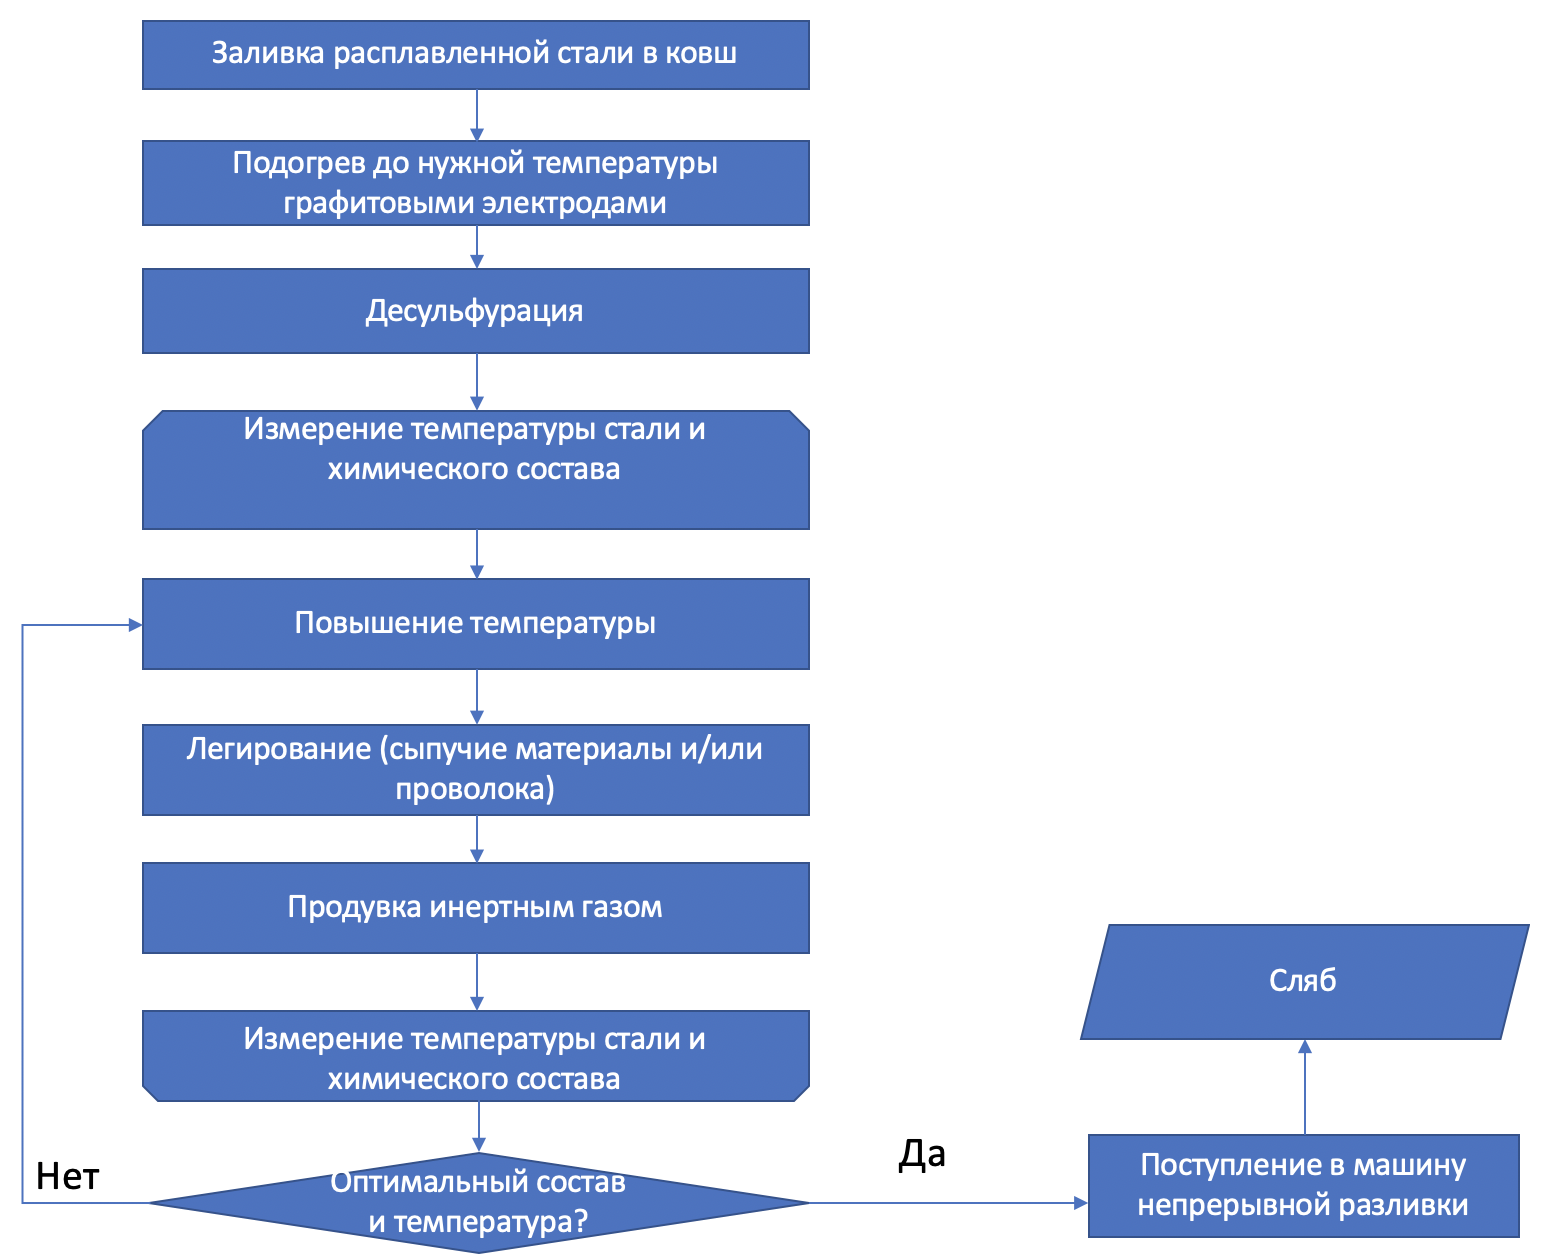

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Содержание проекта**

- [1. Исследовательский анализ данных](#1.-Исследовательский-анализ-данных)
 - [1.1 Результаты измерения температуры](#1.1-Результаты-измерения-температуры)
 - [1.2 Данные об электродах](#1.2-Данные-об-электродах)
 - [1.3 Данные о сыпучих материалах (объем)](#1.3-Данные-о-сыпучих-материалах-(объем))
 - [1.4 Данные о сыпучих материалах (время)](#1.4-Данные-о-сыпучих-материалах-(время))
 - [1.5 Данные о газе](#1.5-Данные-о-газе)
 - [1.6 Данные о проволочных материалах (объем)](#1.6-Данные-о-проволочных-материалах-(объем))
 - [1.7 Данные о проволочных материалах (время)](#1.7-Данные-о-проволочных-материалах-(время))
- [2.1 Предобработка данных](#2.-Предобработка-данных)
 - [2.1 Целевой признак - последняя измеренная температура](#2.1-Целевой-признак---последняя-измеренная-температура)
 - [2.2 Данные об электродах](#2.2-Данные-об-электродах)
 - [2.3 Прочие данные - объем сыпучих материалов, проволоки и данные о продувке газом](#2.3-Прочие-данные---объем-сыпучих-материалов,-проволоки-и-данные-о-продувке-газом)
- [3. Соединение данных](#3.-Соединение-данных)
- [4. Обучение моделей](#4.-Обучение-моделей)
 - [4.1 Подготовка признаков](#4.1-Подготовка-признаков)
 - [4.2 Линейная регрессия](#4.2-Линейная-регрессия)
 - [4.3 Случайный лес](#4.3-Случайный-лес)
 - [4.4 LightGBMRegressor](#4.4-LightGBMRegressor)
 - [4.5 CatBoostRegressor](#4.5-CatBoostRegressor)
 - [4.6 XGBRegressor](#4.6-XGBRegressor) 
- [5. Сравнение моделей и вывод](#5.-Сравнение-моделей-и-вывод)
- [6. Отчёт по основному заданию](#6.-Отчёт-по-основному-заданию)
 - [План решения задачи](#План-решения-задачи)
 - [Сравнение с планом](#Сравнение-с-планом)
 - [Затруднения](#Затруднения)
 - [Ключевые шаги решения](#Ключевые-шаги-решения)
 - [Итоговая модель и сравнение](#Итоговая-модель-и-сравнение)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time
%config InlineBackend.figure_format = 'retina'

# 1. Исследовательский анализ данных

Поскольку у нас несколько файлов, удобно будет создать функцию, которая будет выводить общую информацию и описательную статистику о каждом файле.

In [2]:
def get_info(name_data):
    
    df = pd.read_csv('datasets/final_steel/'+name_data+'.csv')
    display(df.info())
    display(df.describe(include='all' ,datetime_is_numeric=True).T)
    if len(df[df.duplicated()]) == 0:
        print('Дубликатов нет')
    else:
        display(df[df.duplicated()])
    return df

## 1.1 Результаты измерения температуры

Для начала познакомимся с целевым признаком - температурой.

In [3]:
data_temp = get_info('data_temp')
data_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,15907.0,NaN,NaN,NaN,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Время замера,15907,15907,2019-08-12 12:25:47,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Температура,13006.0,NaN,NaN,NaN,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


Дубликатов нет


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Мы видим, что замеров было почти 16 000, но есть пропуски, в результате чего у нас есть 13 006 известных значений температуры.

По условиям задачи, целевой признак - последняя измеренная температура в партии.

Кроме того, нам известно, что будущая модель может принимать первую температуру как признак для обучения.

Соответственно, нам нужно будет выделить первую и последнюю температуру в партии отдельно.

Построим график замеров

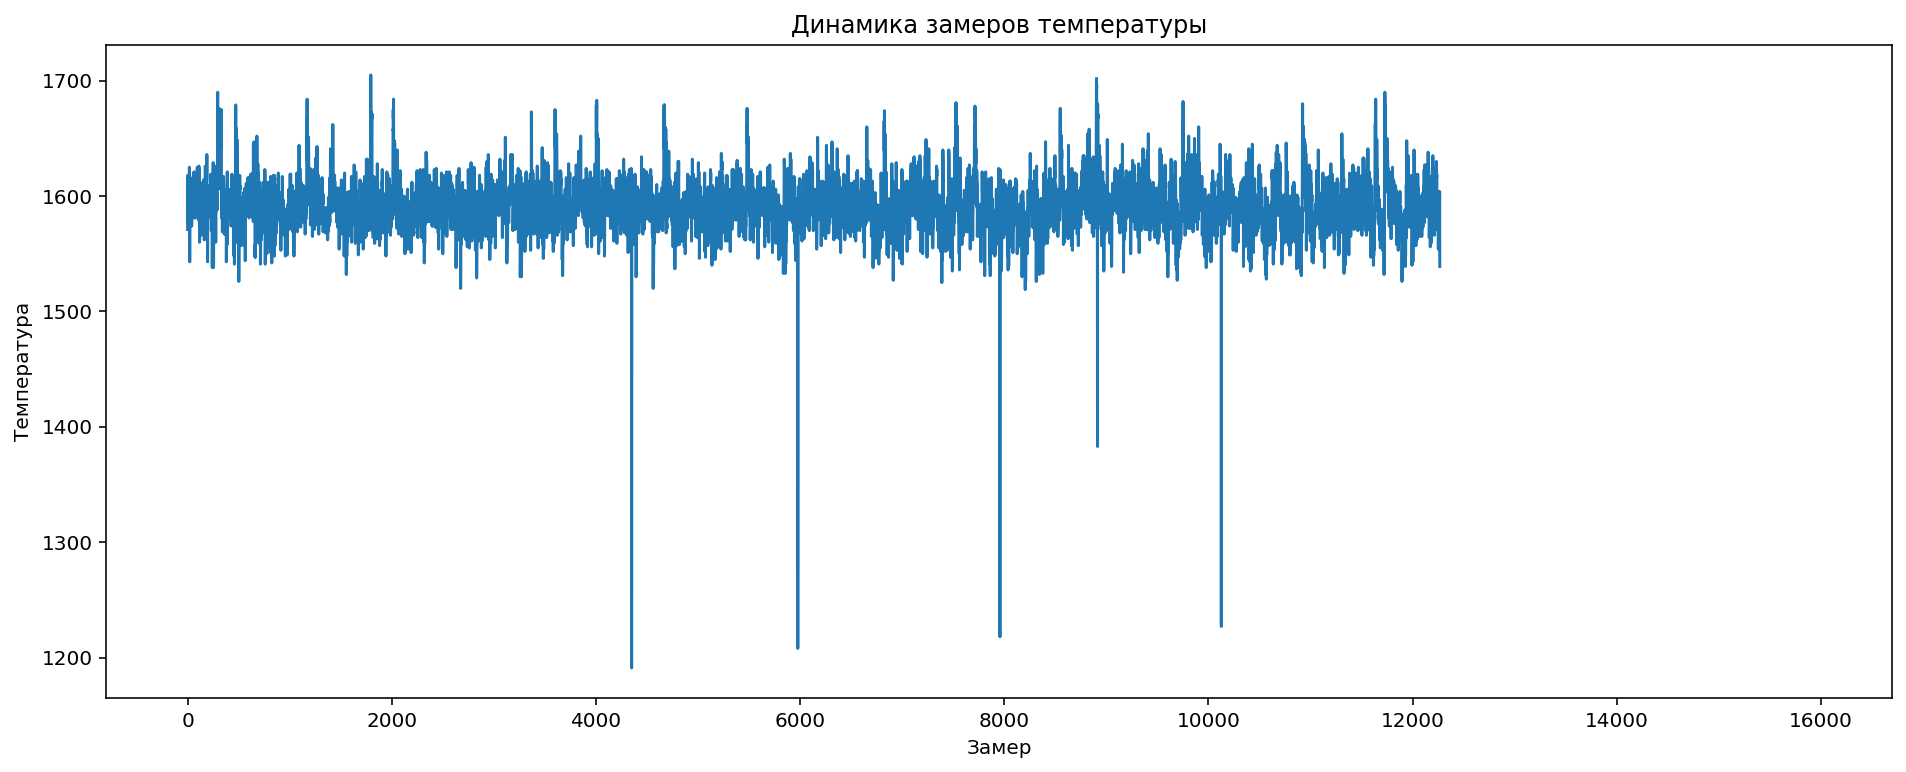

In [4]:
data_temp['Температура'].plot(figsize=(16,6))
plt.title('Динамика замеров температуры')
plt.xlabel('Замер')
plt.ylabel('Температура');

Мы видим, что у нас есть несколько измерений, которые значительно выбиваются от остальных, возможно, это были какие-то аварийные отключения. Так или иначе, в анализе эти аномалии нам помешают. На этапе предобработки данных нужно будет избавится от них.

Посмотрим на замеры с отсутствующей температурой.

In [5]:
data_temp[data_temp.isna().any(axis=1)]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Пропуски в замерах начались с 2500 партии.

Посчитаем количество замеров в партии.

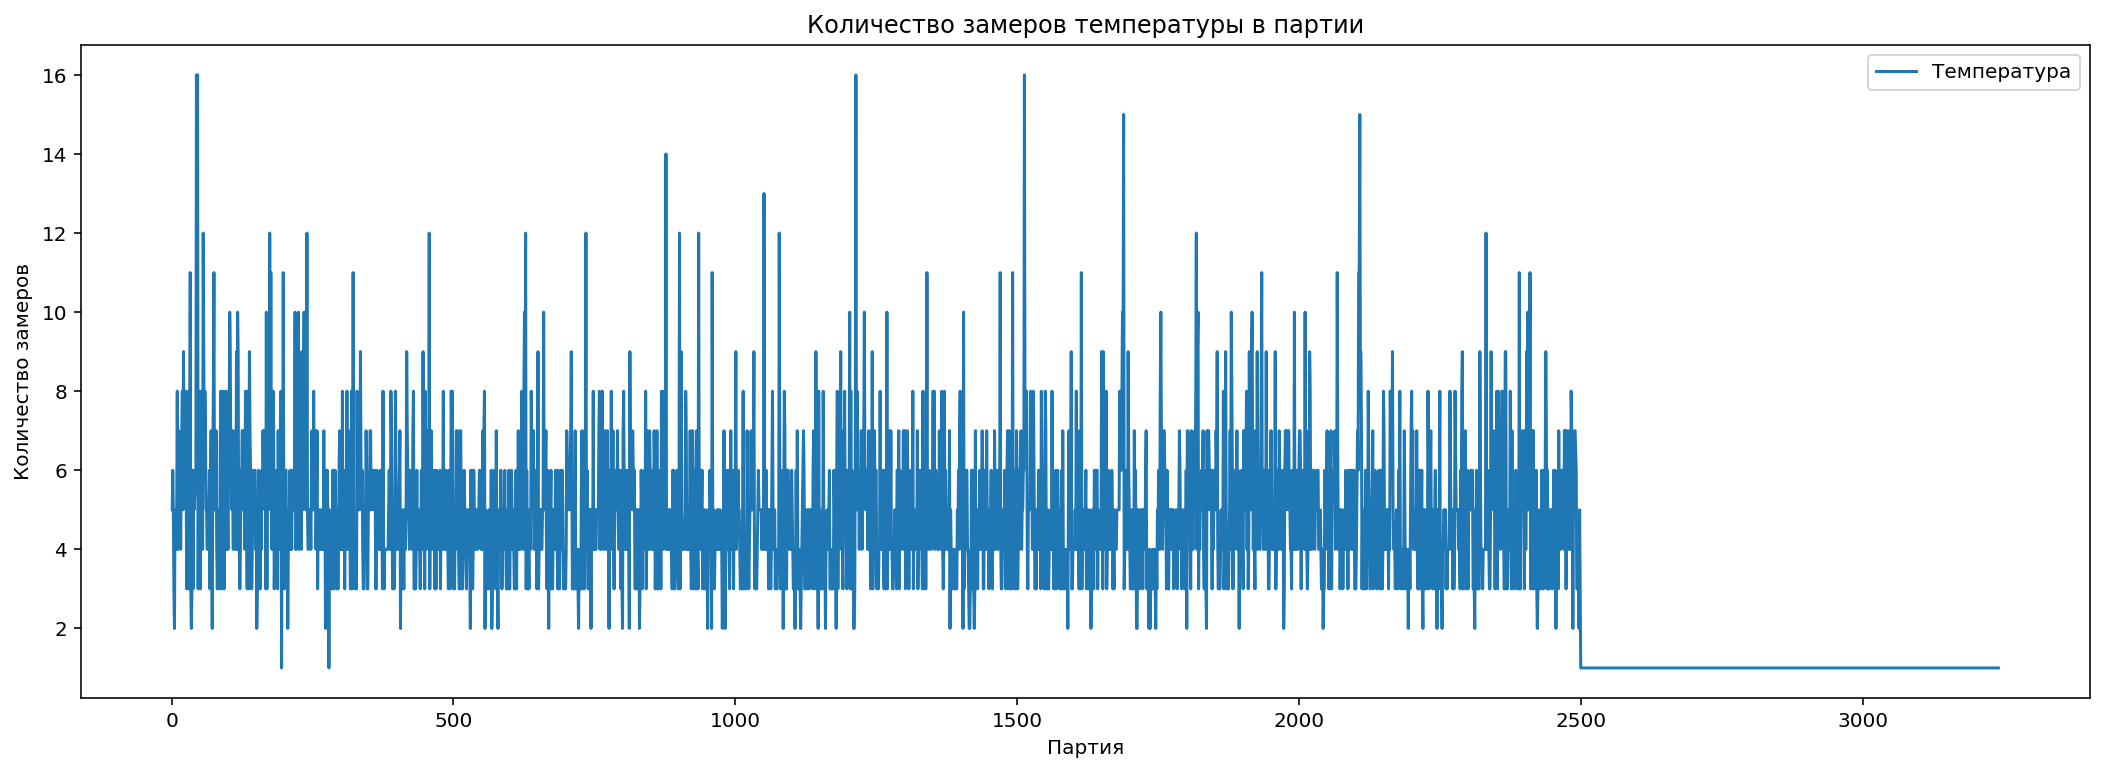

In [6]:
data_temp_count = data_temp.pivot_table(index='key', values='Температура',aggfunc='count')

data_temp_count.plot(figsize=(18,6))
plt.title('Количество замеров температуры в партии')
plt.xlabel('Партия')
plt.ylabel('Количество замеров');

Видно, что начиная с 2500 партии был только один замер температуры на партию.

Выборочно посмотрим на партии с одним замером.

In [7]:
data_temp[data_temp['key'].isin([2503])]

,key,Время замера,Температура
12283,2503,2019-08-06 05:32:06,1603.0
12284,2503,2019-08-06 05:50:37,NaN
12285,2503,2019-08-06 06:00:36,NaN
12286,2503,2019-08-06 06:07:35,NaN


In [8]:
data_temp[data_temp['key'].isin([2705])]

,key,Время замера,Температура
13295,2705,2019-08-13 08:52:08,1578.0
13296,2705,2019-08-13 09:08:42,NaN
13297,2705,2019-08-13 09:16:08,NaN
13298,2705,2019-08-13 09:19:25,NaN


In [9]:
data_temp[data_temp['key'].isin([3105])]

,key,Время замера,Температура
15283,3105,2019-08-27 18:20:35,1549.0
15284,3105,2019-08-27 18:30:45,NaN
15285,3105,2019-08-27 18:37:35,NaN
15286,3105,2019-08-27 18:43:14,NaN
15287,3105,2019-08-27 18:47:42,NaN


Видим, что после того момента, как начались пропуски - был замер только в первой итерации. Убедимся, что это справедливо для всех партий, заполним пропуски нулями.

In [10]:
data_temp['Температура'] = data_temp['Температура'].fillna(0)

Нас интересует последняя температура в партии потому, что это целевой признак. Если после 2500 партии действительно не было замеров в последней итерации, то на графике ниже после 2500 партии мы увидим нули.

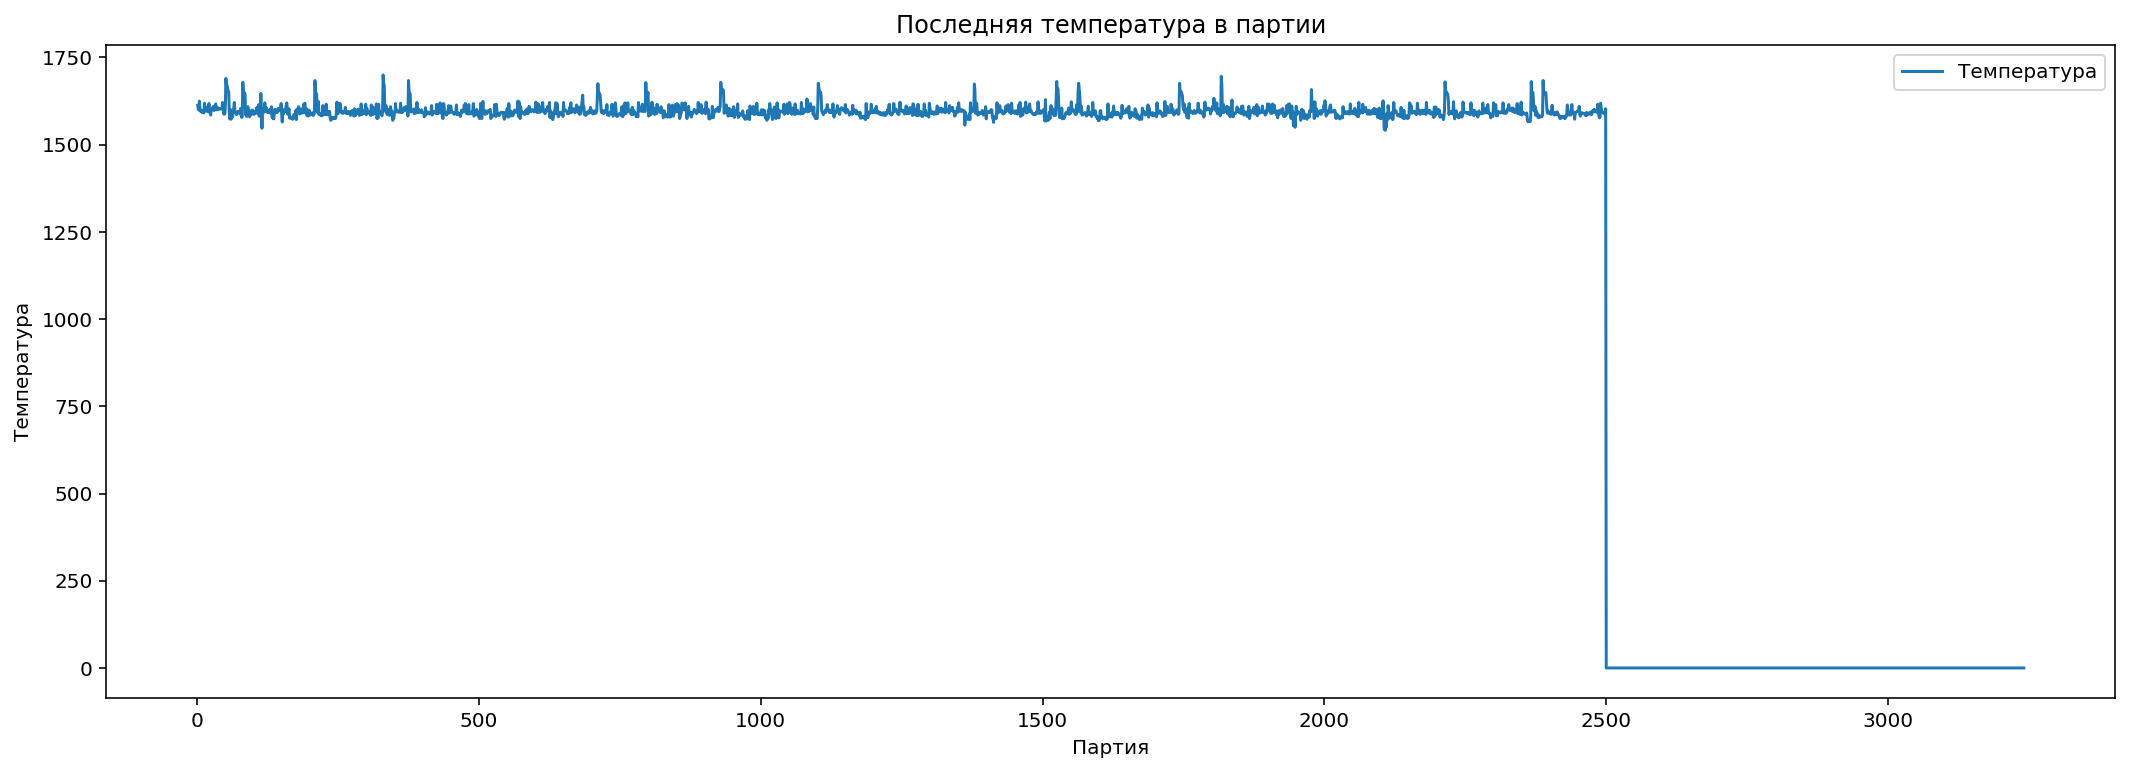

In [11]:
data_temp_last = data_temp.pivot_table(index='key', values='Температура',aggfunc='last')
data_temp_last.plot(figsize=(18,6))
plt.title('Последняя температура в партии')
plt.xlabel('Партия')
plt.ylabel('Температура');

Так и есть, после 2500 партии одни нули, значит, в этих партиях нет необходимо целевого признака и на этих данных обучать модель мы не можем. На этапе предобработки удалим эти данные.

## 1.2 Данные об электродах

Получим информацию об электродах.

In [12]:
data_arc = get_info('data_arc')
data_arc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,14876.0,NaN,NaN,NaN,1615.220422,934.571502,1.0,806.0,1617.0,2429.0,3241.0
Начало нагрева дугой,14876,14875,2019-06-10 22:02:03,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Конец нагрева дугой,14876,14876,2019-05-23 17:30:47,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Активная мощность,14876.0,NaN,NaN,NaN,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,NaN,NaN,NaN,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


Дубликатов нет


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Дубликатов нет.

Здесь данные по замерам мощности относятся ко времени и партии.

Также мы видим, что есть повторяющиеся значения времени замеров. Но по условиям задачи, нас это не должно смущать, так как существует несколько цехов и некоторые процессы могут идти параллельно.

Также нам следует изучить, что такое активная/реактивная мощность.

## 1.3 Данные о сыпучих материалах (объем)

In [13]:
data_bulk = get_info('data_bulk')
data_bulk

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Дубликатов нет


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Здесь мы видим данные о добавках, видно, что всего 15 видов, но далеко не все используются в каждой партии. 

По условиям задачи, нам известно, что пропуски в этой и следующих таблицах означают, что тот или иной вид материала не использовались в партии.

Мы видим, что отрицательных значений в объеме нет, значит, с этой точки зрения - данные релевантны.

## 1.4 Данные о сыпучих материалах (время)

In [14]:
data_bulk_time = get_info('data_bulk_time')
data_bulk_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3129.0,NaN,NaN,NaN,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0
Bulk 1,252,252,2019-06-04 23:36:14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 2,22,22,2019-08-08 08:44:52,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,1298,1298,2019-06-10 11:36:28,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 4,1014,1014,2019-07-15 16:35:29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 5,77,77,2019-07-22 01:58:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 6,576,576,2019-06-30 00:18:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 7,25,25,2019-07-23 15:37:44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 8,1,1,2019-07-05 17:46:11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,19,19,2019-07-18 18:58:01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Дубликатов нет


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


Дубликатов нет. Здесь данные о времени добавления сыпучих материалов.
Вероятно, эта информация для нас лишняя, поскольку мы будем работать с партиями и фактор точного времени для нас не так важен.

## 1.5 Данные о газе

In [15]:
data_gas = get_info('data_gas')
data_gas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Дубликатов нет


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Дубликатов нет. Данные о газе, нет пропусков.

Отрицательных значений также нет.

## 1.6 Данные о проволочных материалах (объем)

In [16]:
data_wire = get_info('data_wire')
data_wire

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442842,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Дубликатов нет


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Дубликатов нет. Первый вид проволоки есть во многих партиях.

Отрицательные значения отсутствуют.

## 1.7 Данные о проволочных материалах (время)

In [17]:
data_wire_time = get_info('data_wire_time')
data_wire_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3081.0,NaN,NaN,NaN,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0
Wire 1,3055,3055,2019-05-20 19:22:40,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 2,1079,1079,2019-05-18 00:10:55,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 3,63,63,2019-06-10 13:19:54,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 4,14,14,2019-05-07 10:14:55,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 5,1,1,2019-08-08 16:01:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,73,73,2019-08-08 20:28:45,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 7,11,11,2019-07-23 12:42:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 8,19,19,2019-05-14 05:14:25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 9,29,29,2019-06-09 10:26:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Дубликатов нет


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Дубликатов нет. Как и в случае с сыпучими материалами, поскольку работаем в привязке к партии, то точное время добавления проволоки для нас вряд ли будет представлять ценность.

# 2. Предобработка данных

Далее займёмся предобработкой и подготовкой данных.

## 2.1 Целевой признак - последняя измеренная температура

Вернемся к таблице с целевым признаком.

Уберем аномально низкие значения температуры и помня, что начиная с 2500 партии нам доступно только первое измерение - отсечем эти данные, которые не сможем использовать при обучении.

In [18]:
data_temp = data_temp[(data_temp['Температура'] > 1400) & (data_temp['key'] <= 2499)]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12261 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12261 non-null  int64  
 1   Время замера  12261 non-null  object 
 2   Температура   12261 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 383.2+ KB


Целевой признак - последняя измеренная температура в партии, найдем ее. Поскольку нам также для обучения, по условию задачи, доступно первое измерение, выделим его.

In [19]:
data_temps = data_temp.pivot_table(index='key', values='Температура', aggfunc=['first','last'])
data_temps.columns = ['first_temp', 'last_temp']
data_temps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_temp  2477 non-null   float64
 1   last_temp   2477 non-null   float64
dtypes: float64(2)
memory usage: 58.1 KB


Поскольку по условию задачи нам доступно первое измерение температуры в партии, выделим отдельно эти значения и соединим их с целевым признаком.

Также исследуем длительность между первым и последним замером температуры в секундах.

In [20]:
data_temp_period = data_temp.pivot_table(index='key', values='Время замера', aggfunc=['first','last','count'])
data_temp_period.columns = ['Время первого замера', 'Время второго замера', 'Количество замеров']
data_temp_period[['Время первого замера', 'Время второго замера']] = data_temp_period[['Время первого замера', 
                                                                'Время второго замера']].astype('datetime64')

data_temp_period['interval'] = (data_temp_period['Время второго замера'] - 
                               data_temp_period['Время первого замера']).dt.total_seconds()

data_temp_period

,Время первого замера,Время второго замера,Количество замеров,interval
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,5,861.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,6,1305.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,5,1300.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,3,388.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,2,762.0
...,...,...,...,...
2495,2019-08-06 00:35:45,2019-08-06 00:54:42,3,1137.0
2496,2019-08-06 01:02:54,2019-08-06 01:29:52,4,1618.0
2497,2019-08-06 01:41:53,2019-08-06 01:53:50,2,717.0


Исследуем распределение длительности интервалов между первым и последним замерами. В дальнейшем нам таким способом предстоит исследовать еще несколько показателей, поэтому создадим функцию.

In [21]:
def plot_and_stat(df,col, title):
    
    sns.set_style('whitegrid')
    ax = plt.subplots(figsize = (16,6))
    
    #ограничим ось абсцисс 2.5 межквартильными размахами
    q_1 = list(df[col].quantile([0.25]))[0]
    q_3 = list(df[col].quantile([0.75]))[0]
    
    chart = sns.histplot(data=df[col]).set_xlim(0, q_3 + 2.5*(q_3 - q_1))
    plt.title(title)
    plt.show()
    
    chart_2 = sns.boxplot(data=df, y=col)
    plt.title(title)
    
    display(df[col].describe());

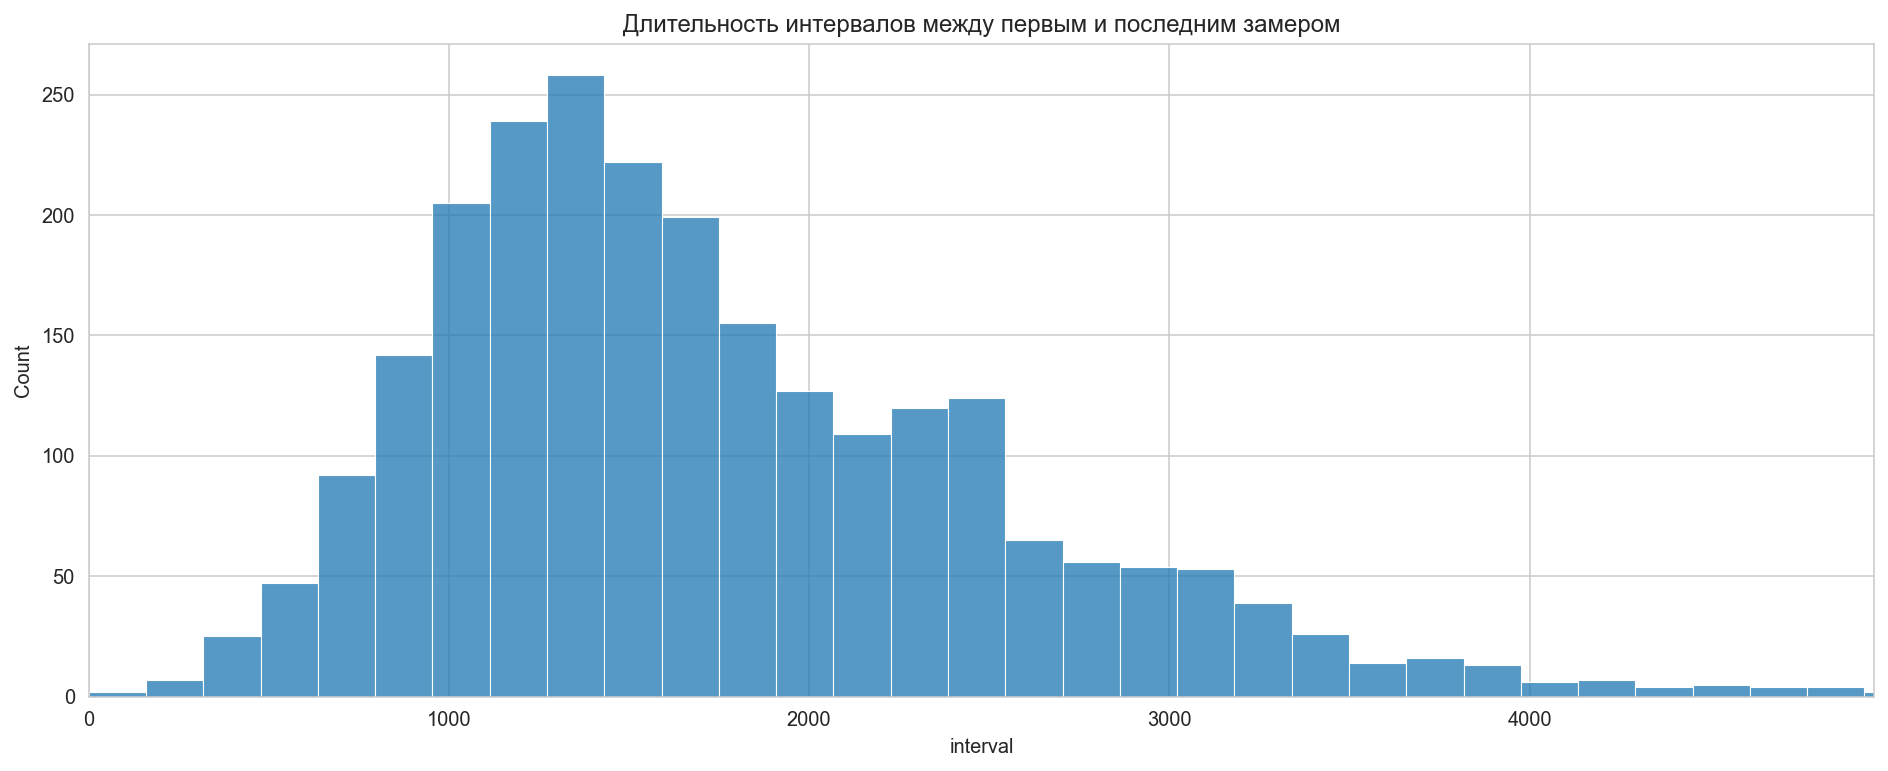

count     2477.000000
mean      1852.801373
std       1301.719007
min          0.000000
25%       1181.000000
50%       1590.000000
75%       2260.000000
max      23537.000000
Name: interval, dtype: float64

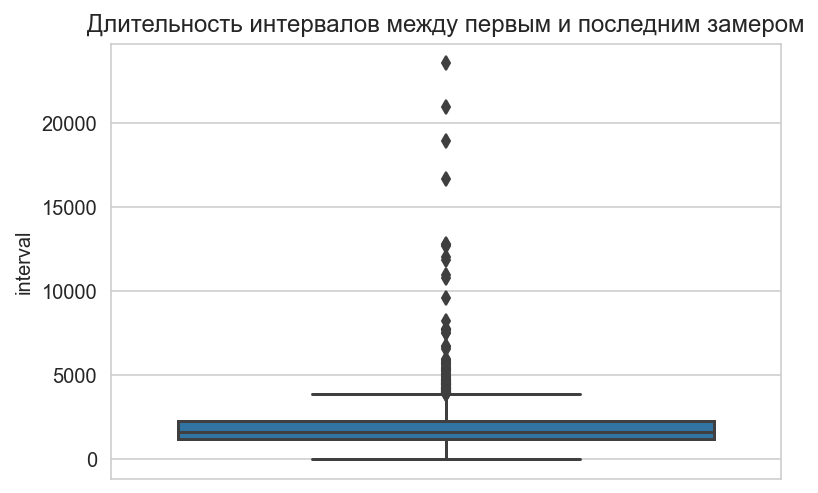

In [22]:
plot_and_stat(data_temp_period,'interval', 'Длительность интервалов между первым и последним замером')

Мы видим, что распределение смещено вправо, средний интервал почти на четыре минуты длиннее медианного. Пока не совсем понятно, как нам могут помочь эти данные.

## 2.2 Данные об электродах

Далее обратимся к данным об электродах.

Разберемся, что такое активная и реактивная мощность.

Во-первых, определимся, что мы говорим об электрической мощности.

**Электрическая мощность** — физическая величина, характеризующая скорость передачи или преобразования электрической энергии.

Среднее за период T значение мгновенной мощности называется активной электрической мощностью или электрической мощностью.
Активная составляющая полной мощности совершает полезную работу и преобразовывается в те виды энергии, которые нужны потребителю.

Физический смысл реактивной мощности — это энергия, перекачиваемая от источника на реактивные элементы приёмника (индуктивности, конденсаторы, обмотки двигателей), а затем возвращаемая этими элементами обратно в источник в течение одного периода колебаний, отнесённая к этому периоду.

**Реактивная мощность** связана с полной мощностью S и активной мощностью P соотношением:

$|Q|=\sqrt {S^{2}-P^{2}}$

**Полная мощность** — величина, равная произведению действующих значений периодического электрического тока I в цепи и напряжения U на её зажимах  S=U * I связана с активной и реактивной мощностями соотношением:

$S={\sqrt {P^{2}+Q^{2}}}$

где P — активная мощность,
Q — реактивная мощность.

Полная мощность имеет практическое значение, как величина, описывающая нагрузки, фактически налагаемые потребителем на элементы подводящей электросети (провода, кабели, распределительные щиты, трансформаторы, линии электропередачи), так как эти нагрузки зависят от потребляемого тока, а не от фактически использованной потребителем энергии. 

Источник: https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C

In [23]:
get_info('data_arc')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,14876.0,NaN,NaN,NaN,1615.220422,934.571502,1.0,806.0,1617.0,2429.0,3241.0
Начало нагрева дугой,14876,14875,2019-06-10 22:02:03,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Конец нагрева дугой,14876,14876,2019-05-23 17:30:47,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Активная мощность,14876.0,NaN,NaN,NaN,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,NaN,NaN,NaN,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


Дубликатов нет


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Исходя из информации выше, реактивная мощность не может быть отрицательной величиной. А мы видим минимальное значение около -715. Выглядит, как аномалия, поэтому стоит отбросить этот объект.

Также мы знаем, что для оубчения нам понадобятся партии с номером до 2500, поэтому имеет смысл отбросить прочие партии из дальнейшего рассмотрения, чтобы они не искажали картину.

In [24]:
data_arc = data_arc[(data_arc['Реактивная мощность'] >0) & (data_arc['key']<2500)]
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11448 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   11448 non-null  int64  
 1   Начало нагрева дугой  11448 non-null  object 
 2   Конец нагрева дугой   11448 non-null  object 
 3   Активная мощность     11448 non-null  float64
 4   Реактивная мощность   11448 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 536.6+ KB


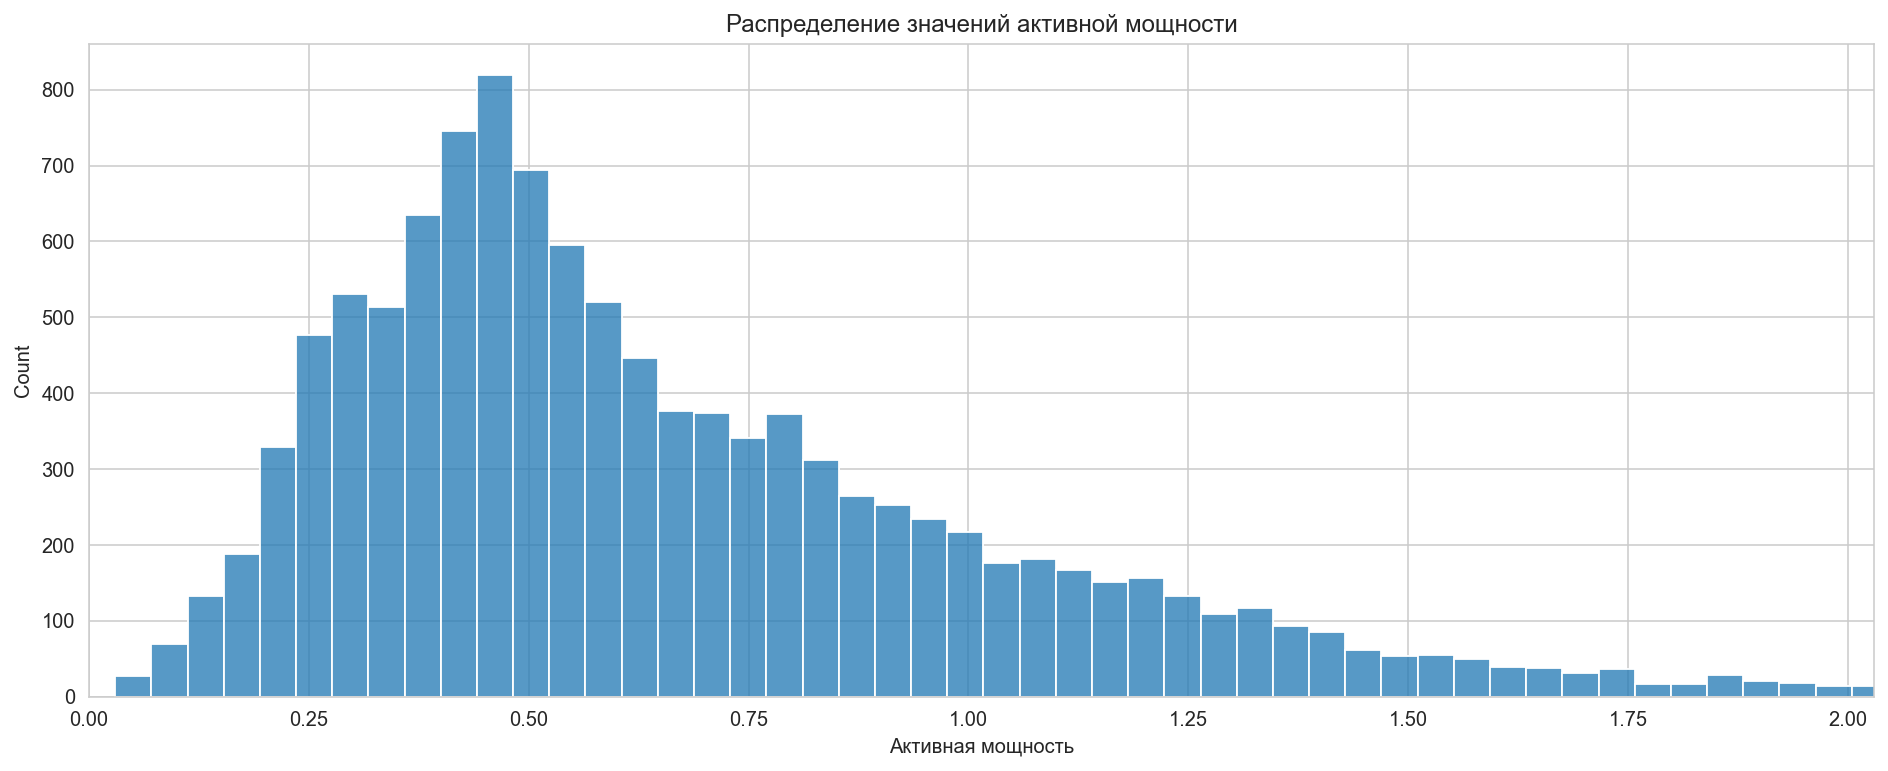

count    11448.000000
mean         0.676134
std          0.408541
min          0.030002
25%          0.398304
50%          0.561410
75%          0.864471
max          3.731596
Name: Активная мощность, dtype: float64

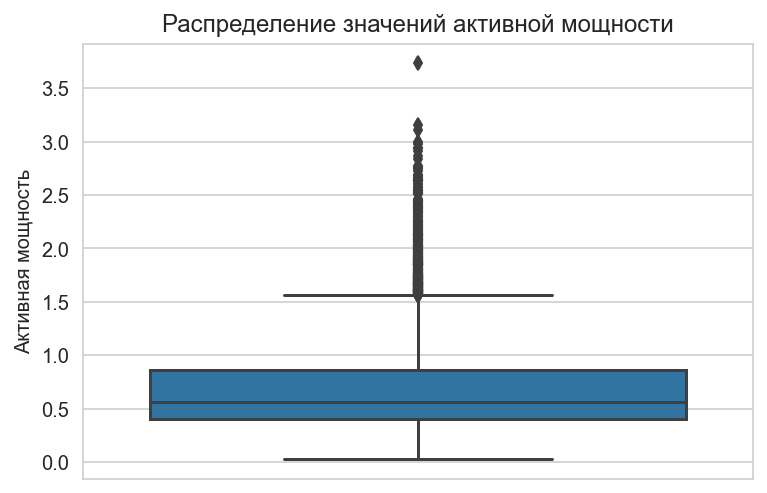

In [25]:
plot_and_stat(data_arc,'Активная мощность', 'Распределение значений активной мощности')

Видно, что распределение значений активной мощности также смещено вправо. Взглянем на реактивную мощность

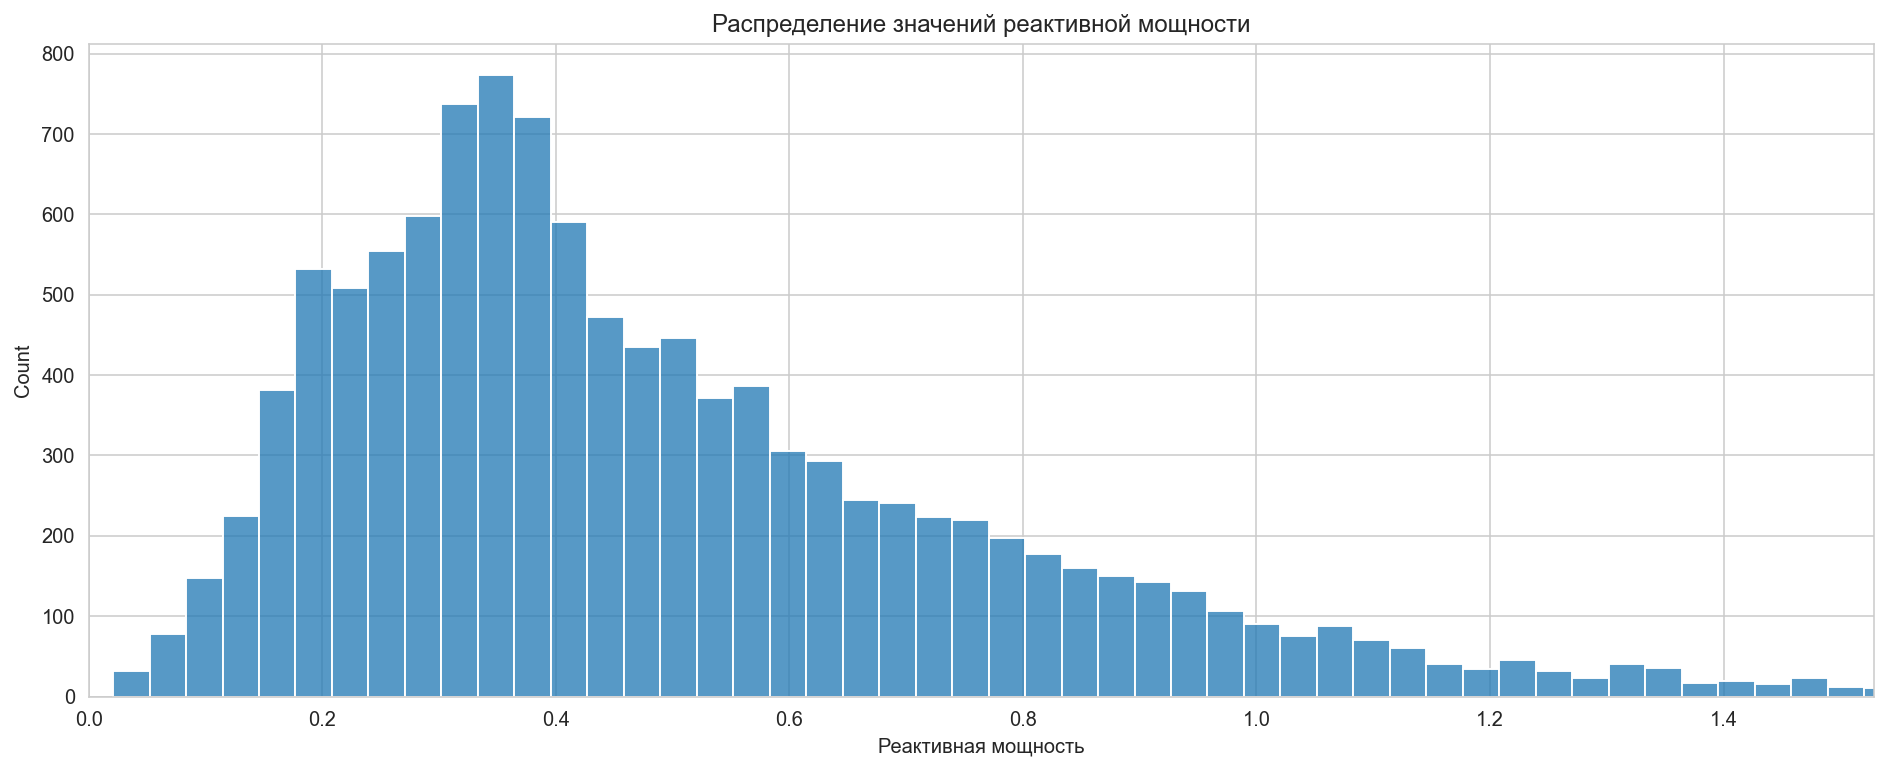

count    11448.000000
mean         0.503883
std          0.310745
min          0.020806
25%          0.291773
50%          0.417518
75%          0.645324
max          2.676388
Name: Реактивная мощность, dtype: float64

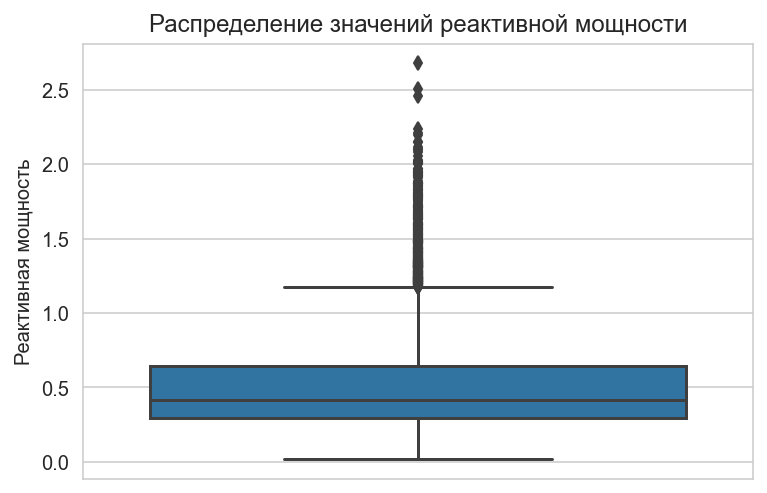

In [26]:
plot_and_stat(data_arc,'Реактивная мощность', 'Распределение значений реактивной мощности')

Распределение смещено немного вправо, то есть, у нас наблюдались скачки в мощности.

Исходя из теоретической информации об электрической мощности, можно сделать предположение, что активная и реактивная мощность могут иметь сильную корреляцию. Если это подтвердится, то, возможно, логичным будет отбросить один из этих признаков.

In [27]:
data_arc[['Активная мощность','Реактивная мощность']].corr()

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.963475
Реактивная мощность,0.963475,1.000000


Да, мы видим, что между величинами сильная корреляция. Сделаем выбор в пользу активной мощности - так как именно эта часть полной мощности совершает полезную работу.

По условиям дополнительного задания, нам предлагается изучить суммарное время нагрева электродами за партию. Для этого посчитаем длительность нагрева за итерацию, а затем просуммируем по партиям.

In [28]:
data_arc[['Начало нагрева дугой', 'Конец нагрева дугой']] = data_arc[['Начало нагрева дугой', 
                                                                'Конец нагрева дугой']].astype('datetime64')

data_arc['heat_time'] = (data_arc['Конец нагрева дугой'] - 
                               data_arc['Начало нагрева дугой']).dt.total_seconds()

data_arc

/Users/andrejvaluhov/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/andrejvaluhov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0
...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,41.0
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,312.0
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,205.0
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,295.0


Также по дополнительному заданию нам следует изучить количество запусков нагрева электродами и среднее соотношение активной и реактивной мощности.

In [29]:
data_arc['Соотношение акт/реакт'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']
data_arc

/Users/andrejvaluhov/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heat_time,Соотношение акт/реакт
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,1.671717
...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,41.0,1.552697
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,312.0,1.366640
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,205.0,1.558461
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,295.0,1.544602


Посмотрим на статистику и распределение рассчитанной величины.

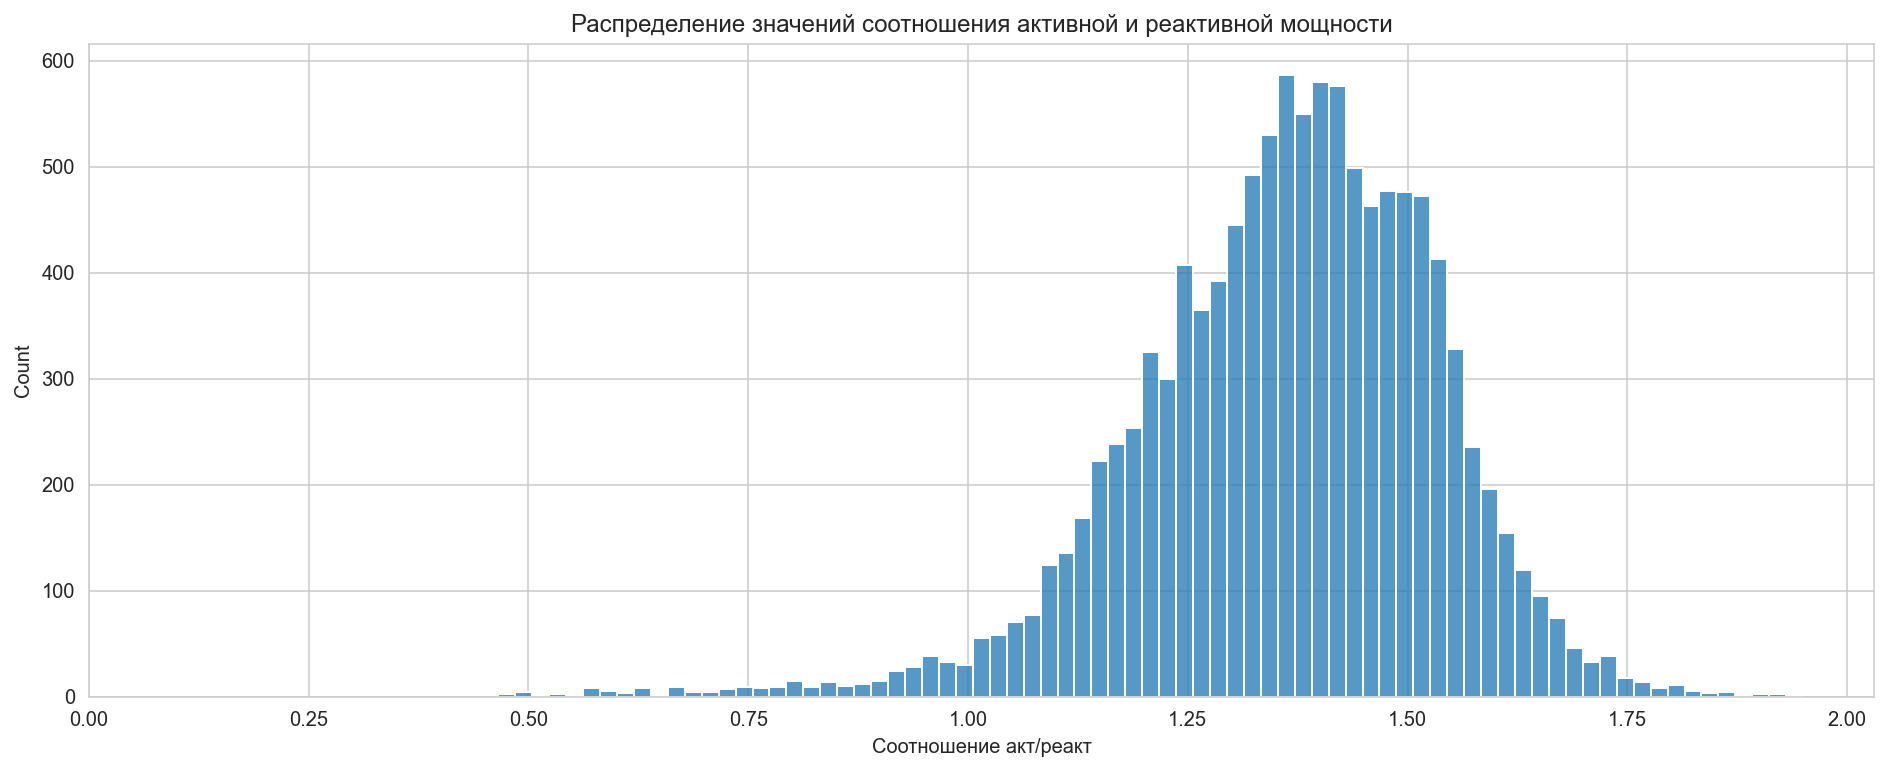

count    11448.000000
mean         1.363893
std          0.170823
min          0.465792
25%          1.263045
50%          1.377592
75%          1.482417
max          1.949831
Name: Соотношение акт/реакт, dtype: float64

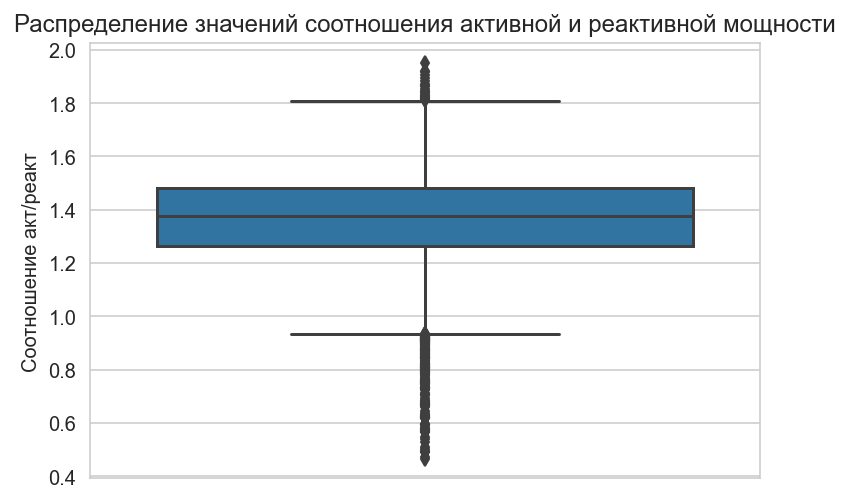

In [30]:
plot_and_stat(data_arc,'Соотношение акт/реакт', 'Распределение значений соотношения активной и реактивной мощности')

Распределение похоже на нормальное, медиана почти равна среднему.

Далее посчитаем суммарное время нагрева электродами за партию ('heat_time') и суммарное количество итераций нагрева за партию ('heat_iters').

In [31]:
data_arc_time = data_arc.pivot_table(index='key', values='heat_time',aggfunc='sum')
data_arc_time

,heat_time
key,
1,1098.0
2,811.0
3,655.0
4,741.0
5,869.0
...,...
2495,723.0
2496,940.0
2497,569.0


In [32]:
data_arc_iters = data_arc.pivot_table(index='key', values='Начало нагрева дугой',aggfunc='count')
data_arc_iters_time = data_arc_iters.join(data_arc_time)
data_arc_iters_time.columns = ['heat_iters','heat_time']
data_arc_iters_time

,heat_iters,heat_time
key,,
1,5,1098.0
2,4,811.0
3,5,655.0
4,4,741.0
5,4,869.0
...,...,...
2495,4,723.0
2496,6,940.0
2497,3,569.0


Посмотрим на статистику запусков нагрева.

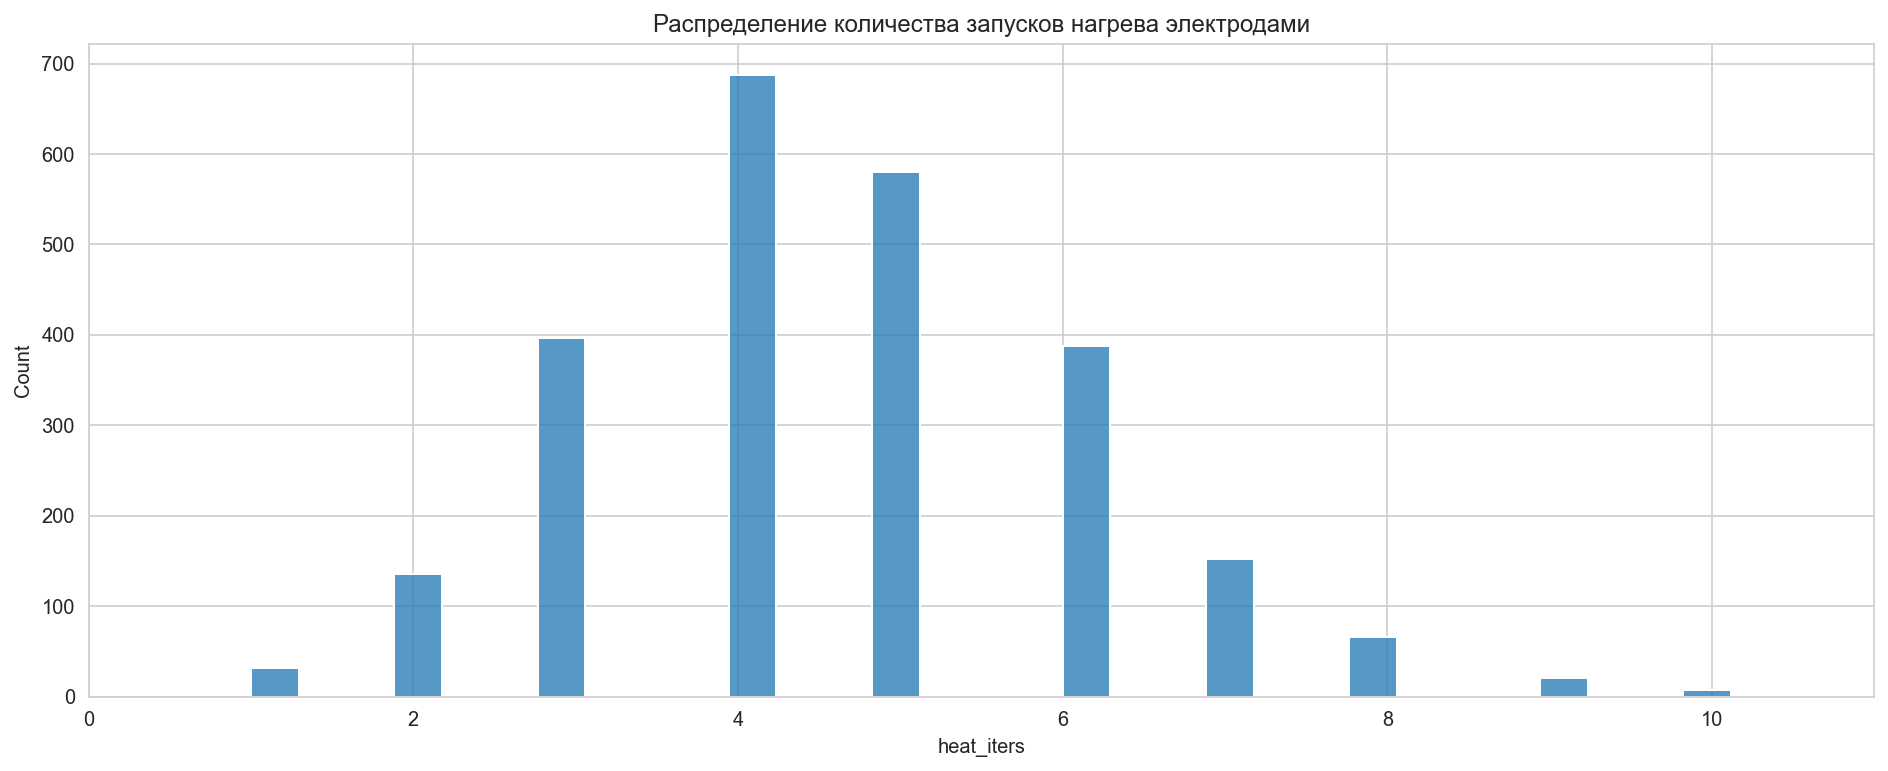

count    2475.000000
mean        4.625455
std         1.610369
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: heat_iters, dtype: float64

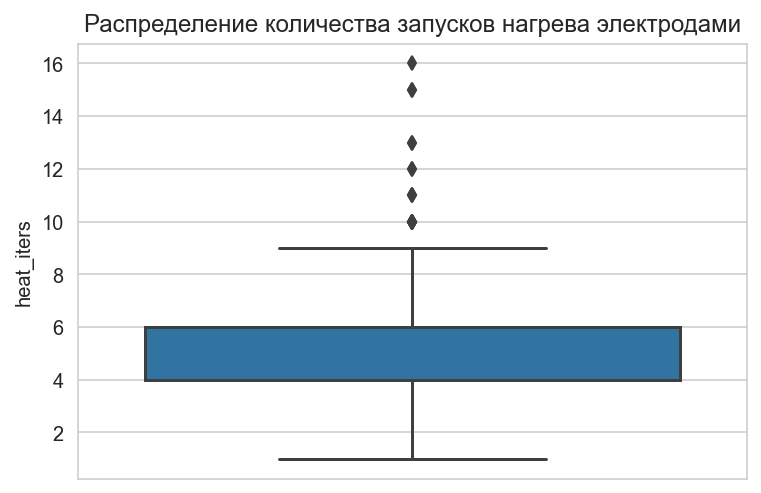

In [33]:
plot_and_stat(data_arc_iters_time,'heat_iters', 'Распределение количества запусков нагрева электродами')

Видим, что распределение немного смещено вправо - среднее превышает медиану. Большая часть значений лежит в области 3-6 итераций нагрева.

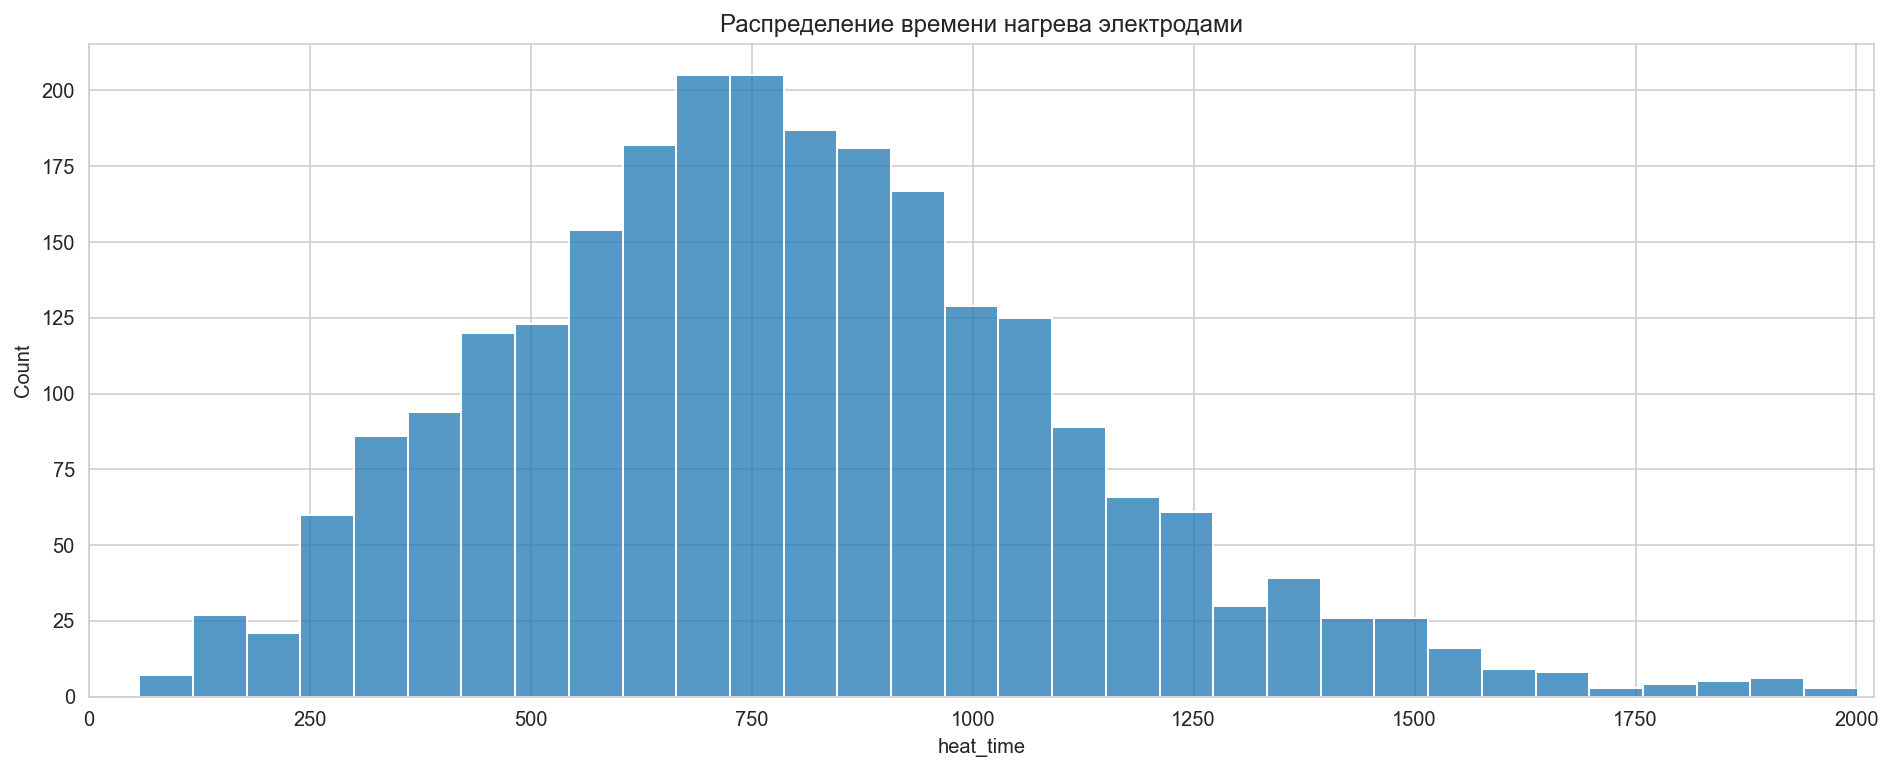

count    2475.000000
mean      799.907879
std       340.838756
min        57.000000
25%       573.000000
50%       772.000000
75%       986.500000
max      4189.000000
Name: heat_time, dtype: float64

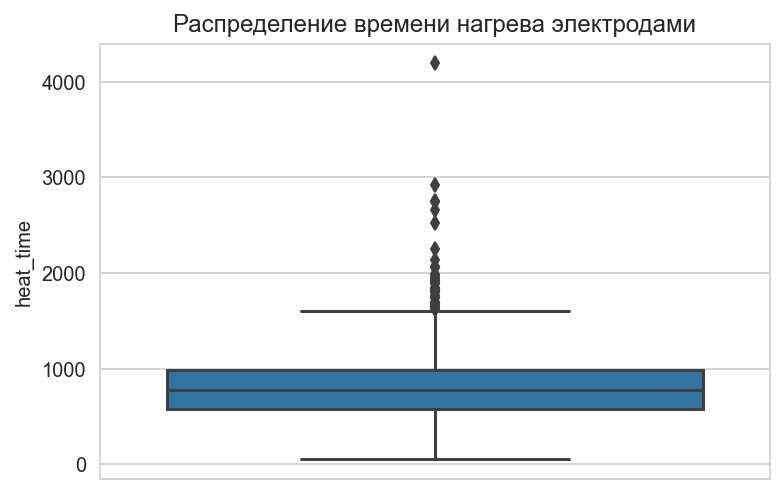

In [34]:
plot_and_stat(data_arc_iters_time,'heat_time', 'Распределение времени нагрева электродами')

Распределение суммарного времени нагрева электродами также похоже на нормальное - медиана и средняя почти совпадают, в среднем нагрев происходил около 13 минут.

Поскольку общее время нагрева и количество итераций нагрева могут служить признаками для обучения, добавим еще один - активную мощность за партию и далее проверим, как эти признаки связаны между собой.

Здесь важно отметить, что мы будем использовать среднее значение активной мощности за партию - более высокое ее значение будет говорить о том, что происходил более интенсивный нагрев, менее высокое - что менее интенсивный.

In [35]:
data_arc_iters_time = data_arc_iters_time.join(data_arc.pivot_table(index='key',values='Активная мощность',aggfunc='mean'))
data_arc_iters_time

,heat_iters,heat_time,Активная мощность
key,,,
1,5,1098.0,0.975629
2,4,811.0,0.763150
3,5,655.0,0.505176
4,4,741.0,0.802313
5,4,869.0,0.836793
...,...,...,...
2495,4,723.0,0.802673
2496,6,940.0,0.700511
2497,3,569.0,0.737460


In [36]:
data_arc_iters_time.corr()

,heat_iters,heat_time,Активная мощность
heat_iters,1.000000,0.795958,0.018129
heat_time,0.795958,1.000000,0.552974
Активная мощность,0.018129,0.552974,1.000000


Заметно, что время нагрева и активная мощность заметно коррелируют, к тому же время нагрева и количество итераций также достаточно сильно коррелируют, поэтому отбросим признак со временем нагрева.

In [37]:
data_arc_power_iters = data_arc_iters_time.drop('heat_time', axis=1)
data_arc_power_iters = data_arc_power_iters.rename(columns={'Активная мощность' : 'power_active'})
data_arc_power_iters

,heat_iters,power_active
key,,
1,5,0.975629
2,4,0.763150
3,5,0.505176
4,4,0.802313
5,4,0.836793
...,...,...
2495,4,0.802673
2496,6,0.700511
2497,3,0.737460


## 2.3 Прочие данные - объем сыпучих материалов, проволоки и данные о продувке газом

На этапе знакомства с данными, мы убедились, что в данных о прочих материалах нет отрицательных значений. Данные о проволоке и сыпучих материалах имеют много признаков, проверять каждый мы не станем. Однако посмотрим на распределение данных о продувке газом.

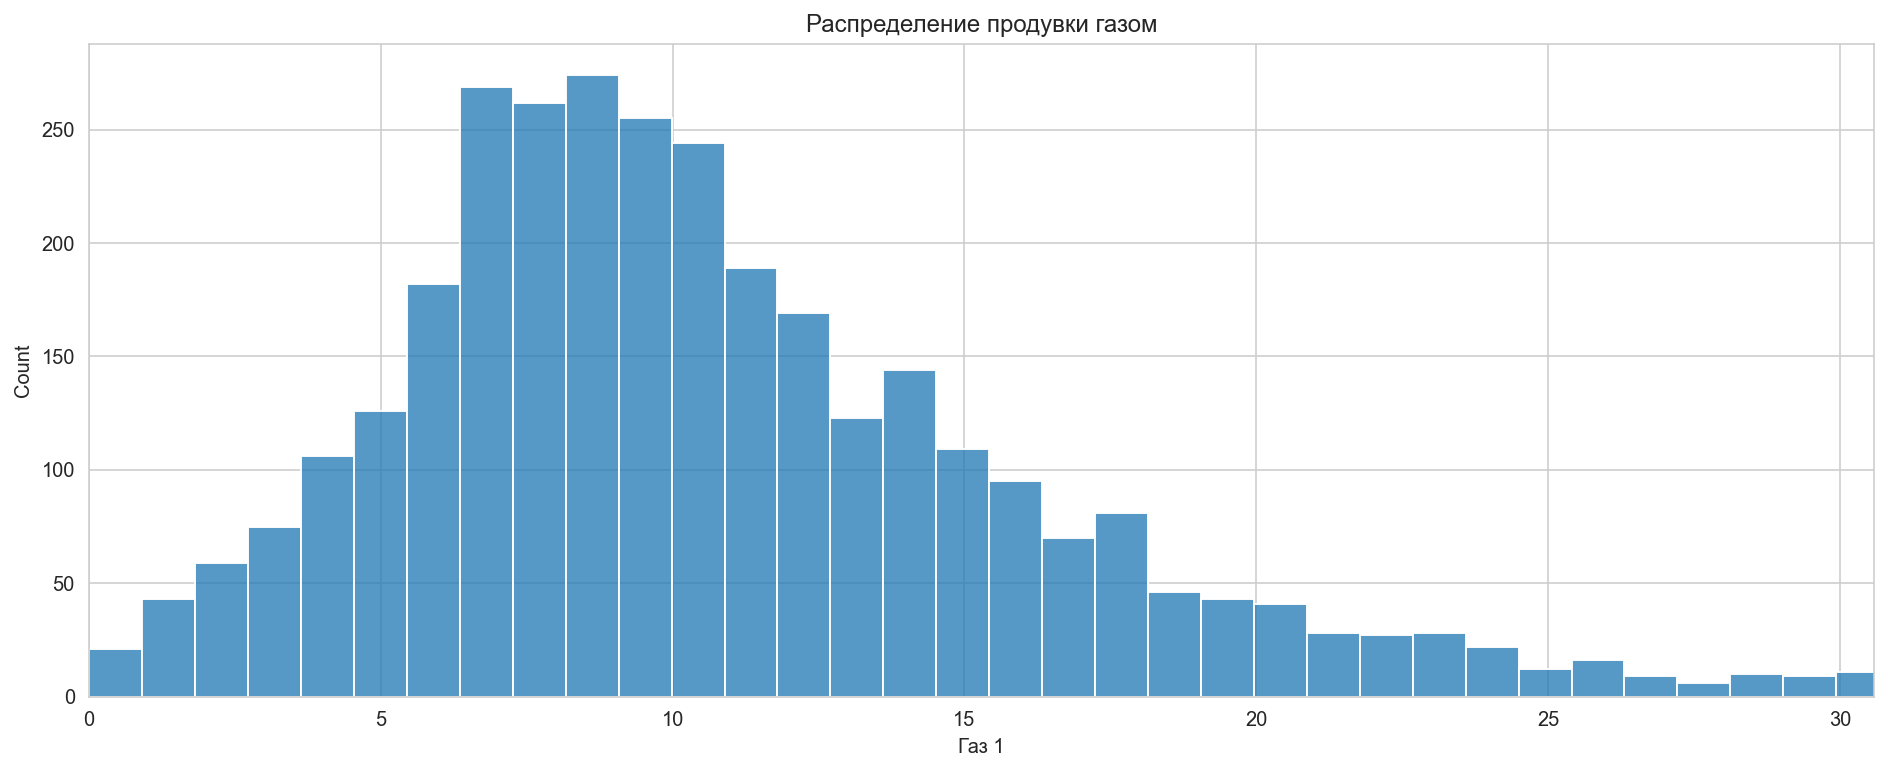

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

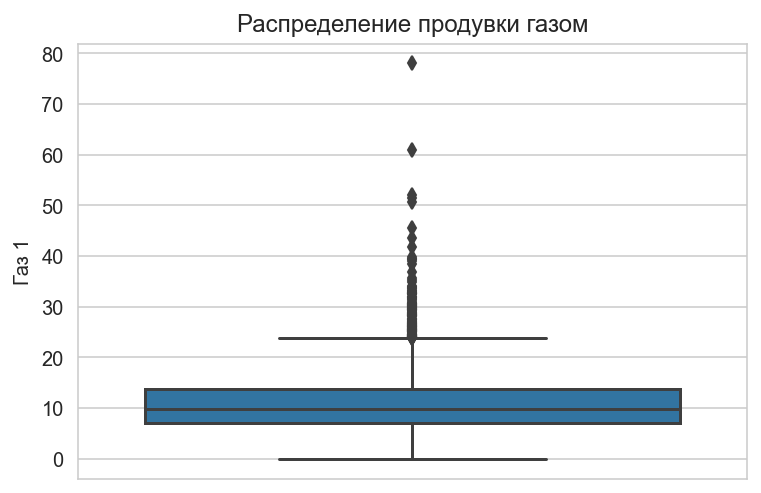

In [38]:
plot_and_stat(data_gas,'Газ 1', 'Распределение продувки газом')

В целом можно сказать, что распределение похоже на нормальное, но были моменты, когда газа поступало достаточно много.

Итак, для прочих данных мы сделаем следующее:
 - заполним пропуски нулями;
 - сделаем столбец 'key' индексом - потому что все данные мы будем соединять по номеру партии.

In [39]:
def fill_and_index(df):
    
    df = df.fillna(0).set_index('key')
    return df

In [40]:
data_gas, data_bulk, data_wire = fill_and_index(data_gas), fill_and_index(data_bulk), fill_and_index(data_wire)
data_gas.columns = ['gas_1']
data_gas

,gas_1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


При знакомстве с данными об объеме сыпучих материалов и проволоки можно было обратить внимание, что некотоыре признаки имеют очень мало ненулевых значений.

Так, например, признаки 'Bulk 8' и 'Wire 5' имеют только одну точку, значит, они нам никак не помогут при прогнозировании. В будущем их нужно удалить.

Взглянем на таблицу корреляций сыпучих материалов и отберем хоть сколько-нибудь заметные связи.

In [41]:
bulk_corr_df = data_bulk.corr()
bulk_corr_df[bulk_corr_df > 0.3]

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
Bulk 1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 2,NaN,1.000000,NaN,NaN,0.412000,NaN,0.757486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 4,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 5,NaN,0.412000,NaN,NaN,1.000000,NaN,0.335044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 7,NaN,0.757486,NaN,NaN,0.335044,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.425791,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.425791,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Отлично, видно, что Bulk 2 и Bulk 7 - признаки, имеющие малое количество точек, достаточно тесно связаны. В таком, случае имеет смысл просуммировать их и создать новый признак 'rare_bulk' вместо них.

In [42]:
data_bulk['rare bulk'] = data_bulk['Bulk 2'] + data_bulk['Bulk 7']

Посмотрим на данные корреляций проволоки.

In [43]:
wire_corr_df = data_wire.corr()
wire_corr_df[wire_corr_df > 0.3]

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Wire 1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Wire 4,NaN,NaN,NaN,1.00000,NaN,0.38632,NaN,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Wire 6,NaN,NaN,NaN,0.38632,NaN,1.00000,NaN,NaN,NaN
Wire 7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Wire 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Wire 9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Видно, что отсноительно тесную связь имеют Wire 4 и Wire 6. Создадим вместо них признак 'rare_wire'.

In [44]:
data_wire['rare wire'] = data_wire['Wire 4'] + data_wire['Wire 6']

# 3. Соединение данных

Итак, теперь соединим все обработанные данные. У нас это:
 - data_temps - целевой признак и первая температура в партии,
 - data_temp_period - по условиям задачи, мы можем использовать время между первым и последним замером для прогнозирования ('interval'),
 - data_arc_power_iters - данные об электродах, полная мощность и количество запусков нагрева,
 - data_gas, data_wire, data_bulk - данные о прочих материалах.

In [45]:
data = data_temps.join([data_temp_period[['interval']], data_arc_power_iters, data_gas, data_wire, data_bulk])
data

,first_temp,last_temp,interval,heat_iters,power_active,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,rare bulk
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,5.0,0.975629,29.749986,60.059998,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0
2,1581.0,1602.0,1305.0,4.0,0.763150,12.555561,96.052315,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0
3,1596.0,1599.0,1300.0,5.0,0.505176,28.554793,91.160157,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0
4,1601.0,1625.0,388.0,4.0,0.802313,18.841219,89.063515,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0
5,1576.0,1602.0,762.0,4.0,0.836793,5.413692,89.238236,9.11456,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,1137.0,4.0,0.802673,7.125735,89.150879,0.00000,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,0.0
2496,1554.0,1591.0,1618.0,6.0,0.700511,9.412616,114.179527,0.00000,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,0.0
2497,1571.0,1589.0,717.0,3.0,0.737460,6.271699,94.086723,9.04800,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,0.0


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_temp    2477 non-null   float64
 1   last_temp     2477 non-null   float64
 2   interval      2477 non-null   float64
 3   heat_iters    2475 non-null   float64
 4   power_active  2475 non-null   float64
 5   gas_1         2475 non-null   float64
 6   Wire 1        2373 non-null   float64
 7   Wire 2        2373 non-null   float64
 8   Wire 3        2373 non-null   float64
 9   Wire 4        2373 non-null   float64
 10  Wire 5        2373 non-null   float64
 11  Wire 6        2373 non-null   float64
 12  Wire 7        2373 non-null   float64
 13  Wire 8        2373 non-null   float64
 14  Wire 9        2373 non-null   float64
 15  rare wire     2373 non-null   float64
 16  Bulk 1        2408 non-null   float64
 17  Bulk 2        2408 non-null   float64
 18  Bulk 3        2408 non-null 

In [47]:
data[data.isna().any(axis=1)]

,first_temp,last_temp,interval,heat_iters,power_active,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,rare bulk
key,,,,,,,,,,,,,,,,,,,,,
51,1619.0,1690.0,1293.0,4.0,1.421179,9.236758,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,1617.0,1669.0,1930.0,6.0,0.842136,14.119615,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,1642.0,1671.0,1996.0,4.0,1.175670,7.090307,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,1630.0,1663.0,1759.0,4.0,0.976084,5.547380,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,1615.0,1654.0,1829.0,4.0,1.149717,8.915683,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,1605.0,1590.0,1391.0,2.0,0.256419,21.884559,55.124157,25.123280,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2434,1635.0,1585.0,1407.0,2.0,0.395635,12.461551,59.099041,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2460,1565.0,1590.0,869.0,4.0,0.611643,1.822347,67.179832,10.103600,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


После объединения таблиц снова получились пропуски. Вероятно, это связано с тем, что во вспомогательных данных отсутствовали партии, которые были в данных об измерении температуры.

Удалим две строки с пропусками в активной мощности, остальные пропуски заполним нулями.

In [48]:
data.dropna(subset=['power_active'],inplace=True)

In [49]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_temp    2475 non-null   float64
 1   last_temp     2475 non-null   float64
 2   interval      2475 non-null   float64
 3   heat_iters    2475 non-null   float64
 4   power_active  2475 non-null   float64
 5   gas_1         2475 non-null   float64
 6   Wire 1        2475 non-null   float64
 7   Wire 2        2475 non-null   float64
 8   Wire 3        2475 non-null   float64
 9   Wire 4        2475 non-null   float64
 10  Wire 5        2475 non-null   float64
 11  Wire 6        2475 non-null   float64
 12  Wire 7        2475 non-null   float64
 13  Wire 8        2475 non-null   float64
 14  Wire 9        2475 non-null   float64
 15  rare wire     2475 non-null   float64
 16  Bulk 1        2475 non-null   float64
 17  Bulk 2        2475 non-null   float64
 18  Bulk 3        2475 non-null 

Также удалим признаки проволоки и сыпучих материалов, которые мы использовали при создании новых признаков, а. также столбцы с данными проволоки и сыпучих материалов, в которых мало точек (меньше 20 - это Bulk 9, Bulk 13, Wire 7, Wire 8, Wire 9).

In [50]:
data = data.drop(['Bulk 8', 'Wire 5', 'Bulk 7','Bulk 2' ,'Wire 6','Wire 4', 'Bulk 9', 'Bulk 13','Wire 7',
                  'Wire 8', 'Wire 9'], axis=1)
data

,first_temp,last_temp,interval,heat_iters,power_active,gas_1,Wire 1,Wire 2,Wire 3,rare wire,...,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,rare bulk
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,5.0,0.975629,29.749986,60.059998,0.00000,0.0,0.0,...,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,0.0
2,1581.0,1602.0,1305.0,4.0,0.763150,12.555561,96.052315,0.00000,0.0,0.0,...,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,0.0
3,1596.0,1599.0,1300.0,5.0,0.505176,28.554793,91.160157,0.00000,0.0,0.0,...,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,0.0
4,1601.0,1625.0,388.0,4.0,0.802313,18.841219,89.063515,0.00000,0.0,0.0,...,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,0.0
5,1576.0,1602.0,762.0,4.0,0.836793,5.413692,89.238236,9.11456,0.0,0.0,...,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,1137.0,4.0,0.802673,7.125735,89.150879,0.00000,0.0,0.0,...,21.0,0.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,0.0
2496,1554.0,1591.0,1618.0,6.0,0.700511,9.412616,114.179527,0.00000,0.0,0.0,...,0.0,63.0,0.0,0.0,122.0,0.0,256.0,129.0,226.0,0.0
2497,1571.0,1589.0,717.0,3.0,0.737460,6.271699,94.086723,9.04800,0.0,0.0,...,0.0,85.0,0.0,0.0,0.0,0.0,230.0,124.0,226.0,0.0


Итак, мы сформировали данные для обучения.

# 4. Обучение моделей

## 4.1 Подготовка признаков

Итак, нам следует отделить целевой признак.

In [51]:
target = data['last_temp']
features = data.drop('last_temp',axis=1)

Разделим данные на обучающую и тестовую выборку в соотношении 70:30, на обучающей выборке будем подбирать гиперпараметры при помощи кросс-валидации.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=2, shuffle=True, test_size=0.3)

Далее, поскольку мы будем обучать модель линейной регрессии, то нам необходимо, что данные были отмасштабированы.

In [53]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=features.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features.columns)

In [54]:
X_test

,first_temp,interval,heat_iters,power_active,gas_1,Wire 1,Wire 2,Wire 3,rare wire,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,rare bulk
0,-0.637461,-0.482627,0.240113,0.551146,0.356444,-0.791955,-0.509408,-0.120603,-0.106753,2.625938,-0.594037,-0.607384,-0.124372,0.982734,-0.234497,-0.177935,-1.296413,-0.590107,1.034102,-0.068427
1,0.317628,-0.709386,-0.384325,-0.221434,-0.601313,-0.391726,-0.509408,-0.120603,-0.106753,-0.271555,-0.594037,2.166183,-0.124372,-0.392031,-0.234497,-0.177935,1.293849,-0.542747,-0.126184,-0.068427
2,-0.677256,-0.811588,0.240113,-0.252968,-0.219123,-0.367818,-0.509408,-0.120603,-0.106753,-0.271555,-0.594037,1.534231,-0.124372,-0.392031,-0.234497,-0.177935,0.026941,-0.009953,1.080513,-0.068427
3,-0.040531,-0.091387,-0.384325,-0.604481,-0.427482,-0.410549,-0.509408,-0.120603,-0.106753,-0.271555,-0.594037,0.638966,-0.124372,-0.392031,-0.234497,-0.177935,-0.010690,-0.305950,-0.137787,-0.068427
4,1.113535,-0.612774,-1.008763,-0.072151,-0.887240,-0.320663,-0.509408,-0.120603,-0.106753,-0.271555,0.125283,-0.607384,-0.124372,-0.392031,-0.234497,-0.177935,-0.637872,0.025566,-1.332882,-0.068427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,0.715581,8.115070,5.235617,1.343489,-0.777597,0.036241,-0.509408,-0.120603,-0.106753,-0.271555,-0.594037,-0.607384,-0.124372,0.963371,-0.234497,-0.177935,-0.016961,2.973693,1.034102,-0.068427
739,0.317628,-0.434720,-1.008763,-1.156658,-0.323522,0.202673,1.746319,-0.120603,-0.106753,-0.271555,-0.594037,-0.607384,-0.124372,-0.392031,-0.234497,-0.177935,0.528687,-0.234911,1.266159,-0.068427
740,0.994149,0.402054,-1.008763,-1.125506,-0.602651,1.095262,-0.053733,-0.120603,-0.106753,-0.271555,-0.594037,-0.607384,-0.124372,-0.392031,-0.234497,-0.177935,-0.023233,-0.199391,-0.102979,-0.068427
741,-0.000735,-1.103820,-1.008763,0.271434,0.118282,-0.176752,-0.509408,-0.120603,-0.106753,-0.271555,-0.594037,3.307208,-0.124372,-0.392031,-0.234497,-0.177935,-0.004418,0.617560,0.453959,-0.068427


Перед обучением моделей узнаем, какую точность дает константная модель. Для этого возьмем медианную последнюю температуру обучающей выборки и предскажем ей целевой признак тестовой выборки.

In [55]:
dummy_mae = mean_absolute_error(y_test, [np.median(y_train) for i in y_test])
print(f'Точность константной модели {dummy_mae:.2f}')

Точность константной модели 10.13


Для полноты картины посмотрим на распределение целевого признака и статистику.

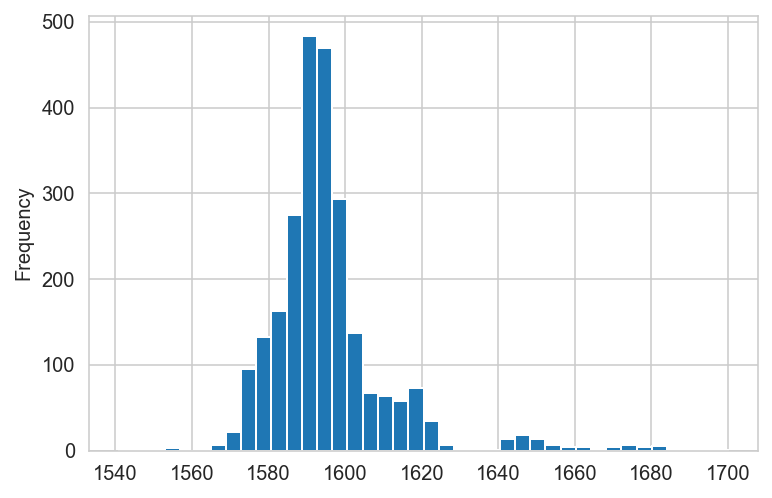

In [56]:
data['last_temp'].plot(kind='hist', bins=40);

In [57]:
data['last_temp'].describe()

count    2475.000000
mean     1595.336162
std        16.023153
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: last_temp, dtype: float64

Заметно, что ошибка константной модели ниже стандартного отклонения.

## 4.2 Линейная регрессия

Итак, сначала обучим модель через алгоритм линейной регрессии.

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_mae = mean_absolute_error(y_test, lin_reg.predict(X_test))
print(f'MAE линейной ргрессии на тестовой выборке: {lin_reg_mae:.2f}')

MAE линейной ргрессии на тестовой выборке: 6.99


Модель показала более высокую точность, по сравнению с константной моделью. Ошибка при этом в 2 раза меньше стандартного отклонения.

## 4.3 Случайный лес

Далее перейдем к случайному лесу, воспользуемся инструментом GridSearchCV, чтобы подобрать гиперпараметры.

In [59]:
rf_model = RandomForestRegressor(random_state=2)

Посмотрим, как алгоритм отработает на гиперпараметрах по умолчанию.

In [60]:
rf_model.fit(X_train, y_train)

mean_absolute_error(y_test, rf_model.predict(X_test))

6.677604306864064

Качество получилось выше, чем у линейной регрессии, посмотрим, поможет ли настройка гиперпараметров.

In [61]:
rf_model = RandomForestRegressor(random_state=2, n_estimators=1000)

forest_params = {
                 'max_depth' : range(19,23,2),                
                 'min_samples_leaf' : range(1,3), 
                 'min_samples_split' : range(2,3),
                }

best_forest = GridSearchCV(rf_model, forest_params, scoring='neg_mean_absolute_error', 
                           cv=5, n_jobs=-1, verbose=True)

best_forest.fit(X_train, y_train)
print(f'MAE Случайного леса на обучающей выборке: {-best_forest.best_score_:.2f}')
print(best_forest.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
MAE Случайного леса на обучающей выборке: 6.59
{'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [62]:
rf_mae = mean_absolute_error(y_test, best_forest.best_estimator_.predict(X_test))
print(f'MAE Случайного леса на тестовой выборке: {rf_mae:.2f}')

MAE Случайного леса на тестовой выборке: 6.66


Удалось незначительно улучшить качество целевой метрики.

Создадим функцию для отображения значимости признаков и посмотрим на самые важные признаки для случайного леса.

In [63]:
def show_importances(gridsearch_object):
    importances = pd.DataFrame({'feature': features.columns,
                'coef' : gridsearch_object.best_estimator_.feature_importances_}).sort_values('coef', ascending=False)
    display (importances.T)

In [64]:
show_importances(best_forest)

,5,0,3,1,18,4,16,17,2,19,13,6,11,10,9,8,15,12,7,14
feature,Wire 1,first_temp,power_active,interval,Bulk 15,gas_1,Bulk 12,Bulk 14,heat_iters,rare bulk,Bulk 6,Wire 2,Bulk 4,Bulk 3,Bulk 1,rare wire,Bulk 11,Bulk 5,Wire 3,Bulk 10
coef,0.370786,0.248253,0.076435,0.037497,0.037102,0.032493,0.032031,0.030983,0.030721,0.025577,0.021251,0.020615,0.011594,0.008359,0.007813,0.002934,0.001585,0.001518,0.001235,0.001219


Стоит отметить, что самыми важными признаками для леса являются данные о легировании первым типом проволоки, о первой температуре и об активной мощности и интервале замера.

## 4.4 LightGBMRegressor

Перейдем к градиентным моделям и начнем с LightGBM на настройках по умолчанию.

In [65]:
lgbm_reg = LGBMRegressor(random_state=2)

lgbm_reg.fit(X_train, y_train, eval_metric='mae',)

lgbm_pred = lgbm_reg.predict(X_test)

print(f'Light_GBM_MAE на тестовой выборке: {mean_absolute_error(y_test, lgbm_pred):.2f}')

Light_GBM_MAE на тестовой выборке: 6.08


По умолчанию LightGBM сразу показал качество выше, чем случайный лес. Попробуем настроить гиперпараметры.

In [66]:
lgbm_reg = LGBMRegressor(random_state=2)
lgbm_params = {
                'learning_rate' : np.arange(0.01,0.1,0.01),
                'max_depth' : range(1,4),
                'n_estimators': range(500,501,100),           
                'reg_lambda' : [0.05,0.1,0.15]         
}

best_lgbm = GridSearchCV(lgbm_reg, lgbm_params, scoring='neg_mean_absolute_error', 
                           cv=5, n_jobs=-1, verbose=True)

best_lgbm.fit(X_train, y_train)
print(f'MAE LightGBM на обучающей выборке {-best_lgbm.best_score_:.2f}')
print(best_lgbm.best_params_)


lgbm_test_pred = best_lgbm.best_estimator_.predict(X_test)
lgbm_mae = mean_absolute_error(y_test, lgbm_test_pred)
print(f'MAE LightGBM на тестовой выборке: {lgbm_mae:.2f}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
MAE LightGBM на обучающей выборке 5.87
{'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 500, 'reg_lambda': 0.1}
MAE LightGBM на тестовой выборке: 5.97


Изменив гиперпараметры, нам удалось повысить точность модели, MAE опустилось ниже 6.

Взглянем на значимость признаков.

In [67]:
show_importances(best_lgbm)

,0,3,2,1,5,17,4,16,9,13,18,6,10,11,15,7,14,12,8,19
feature,first_temp,power_active,heat_iters,interval,Wire 1,Bulk 14,gas_1,Bulk 12,Bulk 1,Bulk 6,Bulk 15,Wire 2,Bulk 3,Bulk 4,Bulk 11,Wire 3,Bulk 10,Bulk 5,rare wire,rare bulk
coef,252,236,204,171,123,107,58,44,34,30,30,29,28,18,14,12,9,8,4,0


Четверкой наиболее значимых признаков выступили те же, что и у случайного леса. Созданные нами признаки можно назвать незначимыми.

## 4.5 CatBoostRegressor

Далее попробуем использовать CatBoost.

In [68]:
cb_reg = CatBoostRegressor(loss_function = 'MAE', verbose=100, random_state=2)

cb_reg.fit(X_train, y_train)

cb_pred = cb_reg.predict(X_test)

cb_mae = mean_absolute_error(y_test, cb_reg.predict(X_test)) 
print(f'MAE_Cat_Boost на тестовой выборке = {cb_mae:.2f}')

0:	learn: 9.7050510	total: 66.6ms	remaining: 1m 6s
100:	learn: 6.0465835	total: 285ms	remaining: 2.54s
200:	learn: 5.1668234	total: 473ms	remaining: 1.88s
300:	learn: 4.5946104	total: 673ms	remaining: 1.56s
400:	learn: 4.1899782	total: 849ms	remaining: 1.27s
500:	learn: 3.9049721	total: 1.04s	remaining: 1.04s
600:	learn: 3.6869636	total: 1.24s	remaining: 823ms
700:	learn: 3.5255097	total: 1.43s	remaining: 609ms
800:	learn: 3.3790736	total: 1.62s	remaining: 402ms
900:	learn: 3.2564467	total: 1.78s	remaining: 196ms
999:	learn: 3.1596412	total: 1.97s	remaining: 0us
MAE_Cat_Boost на тестовой выборке = 5.82


CatBoost по умолчанию еще больше увеличил точность. По опыту коллег известно, что настройка CatBoost редко позволяет существенно увеличить качество. Поэтому оставим модель на настройках по умолчанию.

## 4.6 XGBRegressor

Напоследок испробуем XGBoost.

In [69]:
xgb_reg = XGBRegressor(random_state=2)

xgb_reg.fit(X_train, y_train)

xgb_mae = mean_absolute_error(y_test, xgb_reg.predict(X_test)) 
print(f'MAE_XG_Boost на тестовой выборке ={xgb_mae:.2f}')

[16:20:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE_XG_Boost на тестовой выборке =6.40


Точность не впечатляющая, посмотрим, помогут ли настройки ее повысить.

In [70]:
xgb_reg = XGBRegressor(random_state=2, verbosity=0)

xgb_params = {
                'learning_rate' : np.arange(0.06, 0.08,0.01),
                'max_depth' : range(2,3),
                'n_estimators': range(500,701,100), 
                'reg_lambda' : [0.1,1]         
}

best_xgb = GridSearchCV(xgb_reg, xgb_params, scoring='neg_mean_absolute_error', 
                           cv=5, n_jobs=-1, verbose=True)

best_xgb.fit(X_train, y_train)
print(f'MAE XGBoost на обучающей выборке: {-best_xgb.best_score_:.2f}')
print(best_xgb.best_params_)

xgb_test_pred = best_xgb.best_estimator_.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_test_pred)
print(f'MAE XGBoost на тестовой выборке: {xgb_mae:.2f}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
MAE XGBoost на обучающей выборке: 5.84
{'learning_rate': 0.06999999999999999, 'max_depth': 2, 'n_estimators': 600, 'reg_lambda': 0.1}
MAE XGBoost на тестовой выборке: 5.93


Видим, что MAE составила ниже 6, что является вторым лучшим результатом. Посмотрим на значимость признаков.

In [71]:
show_importances(best_xgb)

,19,8,5,13,0,9,6,3,16,18,2,17,1,4,14,15,11,10,12,7
feature,rare bulk,rare wire,Wire 1,Bulk 6,first_temp,Bulk 1,Wire 2,power_active,Bulk 12,Bulk 15,heat_iters,Bulk 14,interval,gas_1,Bulk 10,Bulk 11,Bulk 4,Bulk 3,Bulk 5,Wire 3
coef,0.300218,0.089812,0.085849,0.071829,0.063565,0.060063,0.058609,0.053647,0.039559,0.033975,0.031353,0.023037,0.019483,0.01636,0.01476,0.010762,0.009988,0.007209,0.00524,0.004682


Интересно, что самыми важными стали признаки, созданные нами.

# 5. Сравнение моделей и вывод

In [72]:
overall = pd.DataFrame(data=[lin_reg_mae, rf_mae, lgbm_mae, cb_mae, xgb_mae, dummy_mae],
                       columns=['MAE на тестовой выборке'],
                      index=['Линейная_регрессия','Случайный_лес', 'Light_GBM', 'CatBoost', 'XGBoost', 'Константная модель'])
overall.sort_values('MAE на тестовой выборке')

,MAE на тестовой выборке
CatBoost,5.819436
XGBoost,5.928309
Light_GBM,5.967910
Случайный_лес,6.656992
Линейная_регрессия,6.994984
Константная модель,10.134590


Итак, видим, что пьедестал заняли градиентные модели, а самым качественным оказался CatBoost.

В рамках работы над задачей было сделано следующее:

1. Познакомились с данными и определили, что данные о времении добавления легирующих элементов не важны для нас.

2. Данные были обработаны - исследовали целевой признак и увидели, что большая часть данных не годится для обучения и предсказания. Также исследовали ряд важных признаков.

3. Провели небольшой процесс feature engineering - создали такие важные для обучения признаки как интервал меджу замервами первой и последней температурой, отобрали значения активной мощности, рассчитали количество итераций нагрева, объединили редкие легирующие добавки в один признак и избавились от скудных признаков.

4. Объединили данные и провели масштабирование количественных переменных.

5. Обучили 5 моделей - линейную регрессию, случайный лес и 3 градиентных модели. Победил CatBoost, показав MAE около 5.8.

Основным итогом данной работы можно считать то, что залогом успеха стало создание новых признаков, исключение лишних признаков и применение градиентных моделей.

Все обученные модели разумны - показали качество выше, чем у константной.